# Integration: MaxFuse and MARIO

This notebook performs cross-modal integration of RNA-seq and CODEX protein data.

## Recommended Workflow

**For cross-modal data (RNA + Protein/CODEX):**
1. Run Steps 1-4 (data loading and preparation)
2. **Skip** MARIO section (designed for same-modality data)
3. Run **MaxFuse Integration** (Step 7+)

**For same-modality data (e.g., CITE-seq + CyTOF):**
1. Run all steps including MARIO

## What Each Method Does

| Method | Best For | Key Feature |
|--------|----------|-------------|
| **MaxFuse** | Cross-modal (RNA↔Protein) | Handles weak feature linkage |
| **MARIO** | Same-modality (Protein↔Protein) | Statistical matchability test |


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import json
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread

# MaxFuse imports
import maxfuse as mf
from maxfuse import Fusor, Mario
from maxfuse.mario import pipelined_mario

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load preprocessed data from 1_preprocessing.ipynb
# Run 1_preprocessing.ipynb first to generate these files

import os

# Fix working directory if notebook started from wrong location
# The notebook expects to run from the notebooks/ directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
if not os.path.exists('../results/1_preprocessing') and os.path.exists('/home/smith6jt/maxfuse/results/1_preprocessing'):
    os.chdir('/home/smith6jt/maxfuse/notebooks')
    print(f"Changed working directory to: {os.getcwd()}")

results_dir = '../results/1_preprocessing'

if not os.path.exists(results_dir):
    raise FileNotFoundError(
        f"Results directory '{results_dir}' not found. "
        f"Run 1_preprocessing.ipynb first to generate the input files."
    )

# Load processed AnnData objects
protein_adata = sc.read_h5ad(f'{results_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{results_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')

print(f"Loaded from {results_dir}/")
print(f"  Protein data: {protein_adata.shape}")
print(f"  RNA data: {rna_adata.shape}")
print(f"  RNA log-normalized: {rna_adata_lognorm.shape}")

# Load preprocessing parameters
with open(f'{results_dir}/preprocessing_params.json', 'r') as f:
    preprocess_params = json.load(f)
print(f"\nPreprocessing timestamp: {preprocess_params['timestamp']}")

Changed working directory to: /home/smith6jt/maxfuse/notebooks
Loaded from ../results/1_preprocessing/
  Protein data: (497676, 19)
  RNA data: (10817, 20951)
  RNA log-normalized: (10817, 20951)

Preprocessing timestamp: 2026-01-22T17:08:28.664891


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [3]:
# Load correspondence table
correspondence = pd.read_csv('../data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

Correspondence table: 370 entries


,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG
5,CD275-1,ICOSLG
6,CD275-2,ICOSLG
7,CD11b,ITGAM
8,CD11b-1,ITGAM
9,CD11b-2,ITGAM


In [4]:
# Find matching features between CODEX markers and RNA genes
# Define markers to exclude (non-immune, structural, or problematic for CD45+ RNA data)
EXCLUDED_MARKERS = [
    'DAPI',           # Nuclear stain
    'ECAD', 'E-cadherin',  # Epithelial
    'IAPP', 'INS', 'GCG', 'SST',  # Pancreatic endocrine
    'Ker8-18', 'Pan-Cytokeratin', 'Keratin 5', 'EpCAM', 'TP63',  # Epithelial
    'Collagen IV', 'Vimentin', 'SMA', 'Caveolin',  # Stromal/structural
    'CD31', 'Podoplanin',  # Endothelial/lymphatic
    'Beta-actin',     # Housekeeping
    'LAG3',          # Excluded per user
]

rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip excluded markers
    if marker in EXCLUDED_MARKERS:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'SMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")
print(f"Excluded {len(EXCLUDED_MARKERS)} non-immune/structural markers")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 19 protein-gene pairs
Excluded 20 non-immune/structural markers


In [5]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")


Final correspondence: 19 pairs

Matched features:
  LAMP1           <-> CD107a
  CD4             <-> CD4
  CD44            <-> CD44
  CD38            <-> CD38
  CD8A            <-> CD8
  PCNA            <-> PCNA
  FOXP3           <-> FOXP3
  B3GAT1          <-> CD57
  MKI67           <-> Ki67
  MS4A1           <-> CD20
  VSIR            <-> VISTA
  PDCD1           <-> PD-1
  TCF7            <-> TCF-1
  TOX             <-> TOX
  CD274           <-> PD-L1
  CD3E            <-> CD3e
  BCL2            <-> Bcl-2
  MPO             <-> MPO
  ENTPD1          <-> CD39


## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [6]:
# Extract shared features from FILTERED data
# Create AnnData objects for shared features to use with scanpy normalization

# Get the gene/protein names from correspondence
shared_rna_genes = rna_protein_correspondence[:, 0]  # RNA gene names
shared_protein_markers = rna_protein_correspondence[:, 1]  # Protein marker names

# Verify all features exist
missing_rna = [g for g in shared_rna_genes if g not in rna_adata.var_names]
missing_prot = [p for p in shared_protein_markers if p not in protein_adata.var_names]

if missing_rna:
    print(f"WARNING: Missing RNA genes: {missing_rna}")
if missing_prot:
    print(f"WARNING: Missing protein markers: {missing_prot}")

# Create shared feature AnnData objects
rna_shared_adata = rna_adata[:, shared_rna_genes].copy()
protein_shared_adata = protein_adata[:, shared_protein_markers].copy()

print(f"Shared feature AnnData objects created:")
print(f"  rna_shared_adata: {rna_shared_adata.shape}")
print(f"  protein_shared_adata: {protein_shared_adata.shape}")
print(f"\nRNA shared features: {list(rna_shared_adata.var_names[:5])}...")
print(f"Protein shared features: {list(protein_shared_adata.var_names[:5])}...")

Shared feature AnnData objects created:
  rna_shared_adata: (10817, 19)
  protein_shared_adata: (497676, 19)

RNA shared features: ['LAMP1', 'CD4', 'CD44', 'CD38', 'CD8A']...
Protein shared features: ['CD107a', 'CD4', 'CD44', 'CD38', 'CD8']...


In [7]:
# Normalize shared features
# KEY INSIGHT: RNA and protein have DIFFERENT data characteristics
# - RNA: Sparse (many true zeros = undetected), needs detection-aware normalization
# - Protein: Continuous (no true zeros, just low expression), needs standard z-score

from scipy import sparse, stats
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ============================================================
# EXTRACT RAW DATA
# ============================================================

rna_shared_raw = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared_raw):
    rna_shared_raw = rna_shared_raw.toarray()

protein_shared_raw = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared_raw):
    protein_shared_raw = protein_shared_raw.toarray()

print("=" * 70)
print("SHARED FEATURE NORMALIZATION")
print("=" * 70)
print(f"\nCell counts: RNA = {rna_shared_raw.shape[0]:,}, Protein = {protein_shared_raw.shape[0]:,}")

# Fixed value for RNA undetected values
ZERO_VALUE = -3.0

# ============================================================
# LOAD GATES FOR PROTEIN DETECTION (for visualization only)
# ============================================================

gates = protein_adata.uns['gates']
protein_log_layer = protein_adata.layers['log']

shared_marker_names = [prot_name for rna_name, prot_name in rna_protein_correspondence]

# Extract log values for gate-based detection (used for visualization)
protein_log_shared = np.zeros((protein_shared_adata.n_obs, len(shared_marker_names)))
protein_gates = np.zeros(len(shared_marker_names))

for i, marker in enumerate(shared_marker_names):
    if marker in protein_adata.var_names:
        marker_idx = list(protein_adata.var_names).index(marker)
        protein_log_shared[:, i] = protein_log_layer[:, marker_idx]
        if marker in gates.index:
            protein_gates[i] = gates.loc[marker, 'gates']
        else:
            protein_gates[i] = np.median(protein_log_shared[:, i])

# Detection mask for protein (gate-based) - used for visualization
protein_detection_mask = protein_log_shared > protein_gates[np.newaxis, :]

print("\n" + "="*70)
print("PROTEIN DETECTION RATES (gate-based, for reference)")
print("="*70)
print(f"{'Marker':<12} {'Gate':>8} {'% Positive':>12}")
print("-"*34)
for i, (rna_name, prot_name) in enumerate(rna_protein_correspondence[:10]):
    det_rate = protein_detection_mask[:, i].mean() * 100
    print(f"{prot_name[:11]:<12} {protein_gates[i]:>8.2f} {det_rate:>11.1f}%")
if len(rna_protein_correspondence) > 10:
    print("...")

# ============================================================
# RNA NORMALIZATION: Detection-Aware (sparse data with true zeros)
# ============================================================

print("\n" + "="*70)
print("RNA NORMALIZATION (Detection-Aware for Sparse Data)")
print("="*70)
print(f"  Raw zeros: {(rna_shared_raw == 0).mean()*100:.1f}%")

# Step 1: Library size normalization
sc.pp.normalize_total(rna_shared_adata, target_sum=1e4)

# Step 2: Log transform
sc.pp.log1p(rna_shared_adata)
rna_after_log = rna_shared_adata.X.copy()
if sparse.issparse(rna_after_log):
    rna_after_log = rna_after_log.toarray()

# RNA detection mask: non-zero after log1p (true biological zeros)
rna_detection_mask = rna_after_log > 0
print(f"  After log1p: {rna_detection_mask.mean()*100:.1f}% detected (non-zero)")

# Detection-aware normalization for RNA
def detection_aware_normalize_rna(data, detection_mask, zero_value=ZERO_VALUE):
    """Z-score detected values only, set undetected to fixed value."""
    n_cells, n_features = data.shape
    normalized = np.full_like(data, zero_value, dtype=np.float64)
    
    for j in range(n_features):
        detected_idx = detection_mask[:, j]
        if detected_idx.sum() > 1:
            vals = data[detected_idx, j]
            z_vals = (vals - vals.mean()) / (vals.std() + 1e-8)
            z_vals = np.clip(z_vals, -5, 5)
            normalized[detected_idx, j] = z_vals
    
    return normalized

rna_shared_normalized = detection_aware_normalize_rna(rna_after_log, rna_detection_mask)

# Stats for detected values only
rna_detected_vals = rna_shared_normalized[rna_detection_mask]
print(f"\n  Detected values: mean={rna_detected_vals.mean():.4f}, std={rna_detected_vals.std():.4f}")
print(f"  Undetected set to: {ZERO_VALUE}")

# ============================================================
# PROTEIN NORMALIZATION: Standard Z-score (continuous data)
# ============================================================

print("\n" + "="*70)
print("PROTEIN NORMALIZATION (Standard Z-score for Continuous Data)")
print("="*70)
print(f"  Shape: {protein_shared_raw.shape}")
print(f"  Raw: mean={protein_shared_raw.mean():.3f}, std={protein_shared_raw.std():.3f}")

# Standard z-score on ALL values (protein is continuous, not sparse)
scaler = StandardScaler()
protein_shared_normalized = scaler.fit_transform(protein_shared_raw)
protein_shared_normalized = np.clip(protein_shared_normalized, -5, 5)

print(f"\n  After z-score: mean={protein_shared_normalized.mean():.4f}, std={protein_shared_normalized.std():.4f}")
print(f"  Range: [{protein_shared_normalized.min():.2f}, {protein_shared_normalized.max():.2f}]")

# ============================================================
# STORE RESULTS
# ============================================================

# Final normalized arrays
rna_shared = rna_shared_normalized.astype(np.float32)
protein_shared = protein_shared_normalized.astype(np.float32)

# Compatibility names
rna_shared_after_scale = rna_shared
protein_shared_after = protein_shared

# Update AnnData objects
rna_shared_adata.X = rna_shared
protein_shared_adata.X = protein_shared

# ============================================================
# VERIFICATION
# ============================================================

print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

print("\nRNA (detected values only):")
print(f"  mean={rna_detected_vals.mean():.4f}, std={rna_detected_vals.std():.4f}")

print("\nProtein (all values):")
print(f"  mean={protein_shared.mean():.4f}, std={protein_shared.std():.4f}")

print("\n" + "="*70)
print("SUCCESS: Normalization complete!")
print("- RNA: Detection-aware (zeros → fixed value, detected → z-score)")
print("- Protein: Standard z-score on all values (continuous data)")
print("="*70)

SHARED FEATURE NORMALIZATION

Cell counts: RNA = 10,817, Protein = 497,676

PROTEIN DETECTION RATES (gate-based, for reference)
Marker           Gate   % Positive
----------------------------------
CD107a           5.60        22.4%
CD4              6.90         4.2%
CD44             6.90        13.7%
CD38             6.50         0.2%
CD8              7.40         3.2%
PCNA             5.80        46.4%
FOXP3            7.20         0.1%
CD57             5.10         0.3%
Ki67             5.50         0.1%
CD20             6.40         1.1%
...

RNA NORMALIZATION (Detection-Aware for Sparse Data)
  Raw zeros: 83.0%
  After log1p: 17.0% detected (non-zero)

  Detected values: mean=-0.0000, std=1.0000
  Undetected set to: -3.0

PROTEIN NORMALIZATION (Standard Z-score for Continuous Data)
  Shape: (497676, 19)
  Raw: mean=0.426, std=0.092

  After z-score: mean=-0.0050, std=0.9616
  Range: [-5.00, 5.00]

VERIFICATION

RNA (detected values only):
  mean=-0.0000, std=1.0000

Protein (all v

Example feature: TCF7 / TCF-1
  RNA detection: 27.3% (2,948 cells)
  Protein detection (gate-based): 98.6% (490,949 cells)


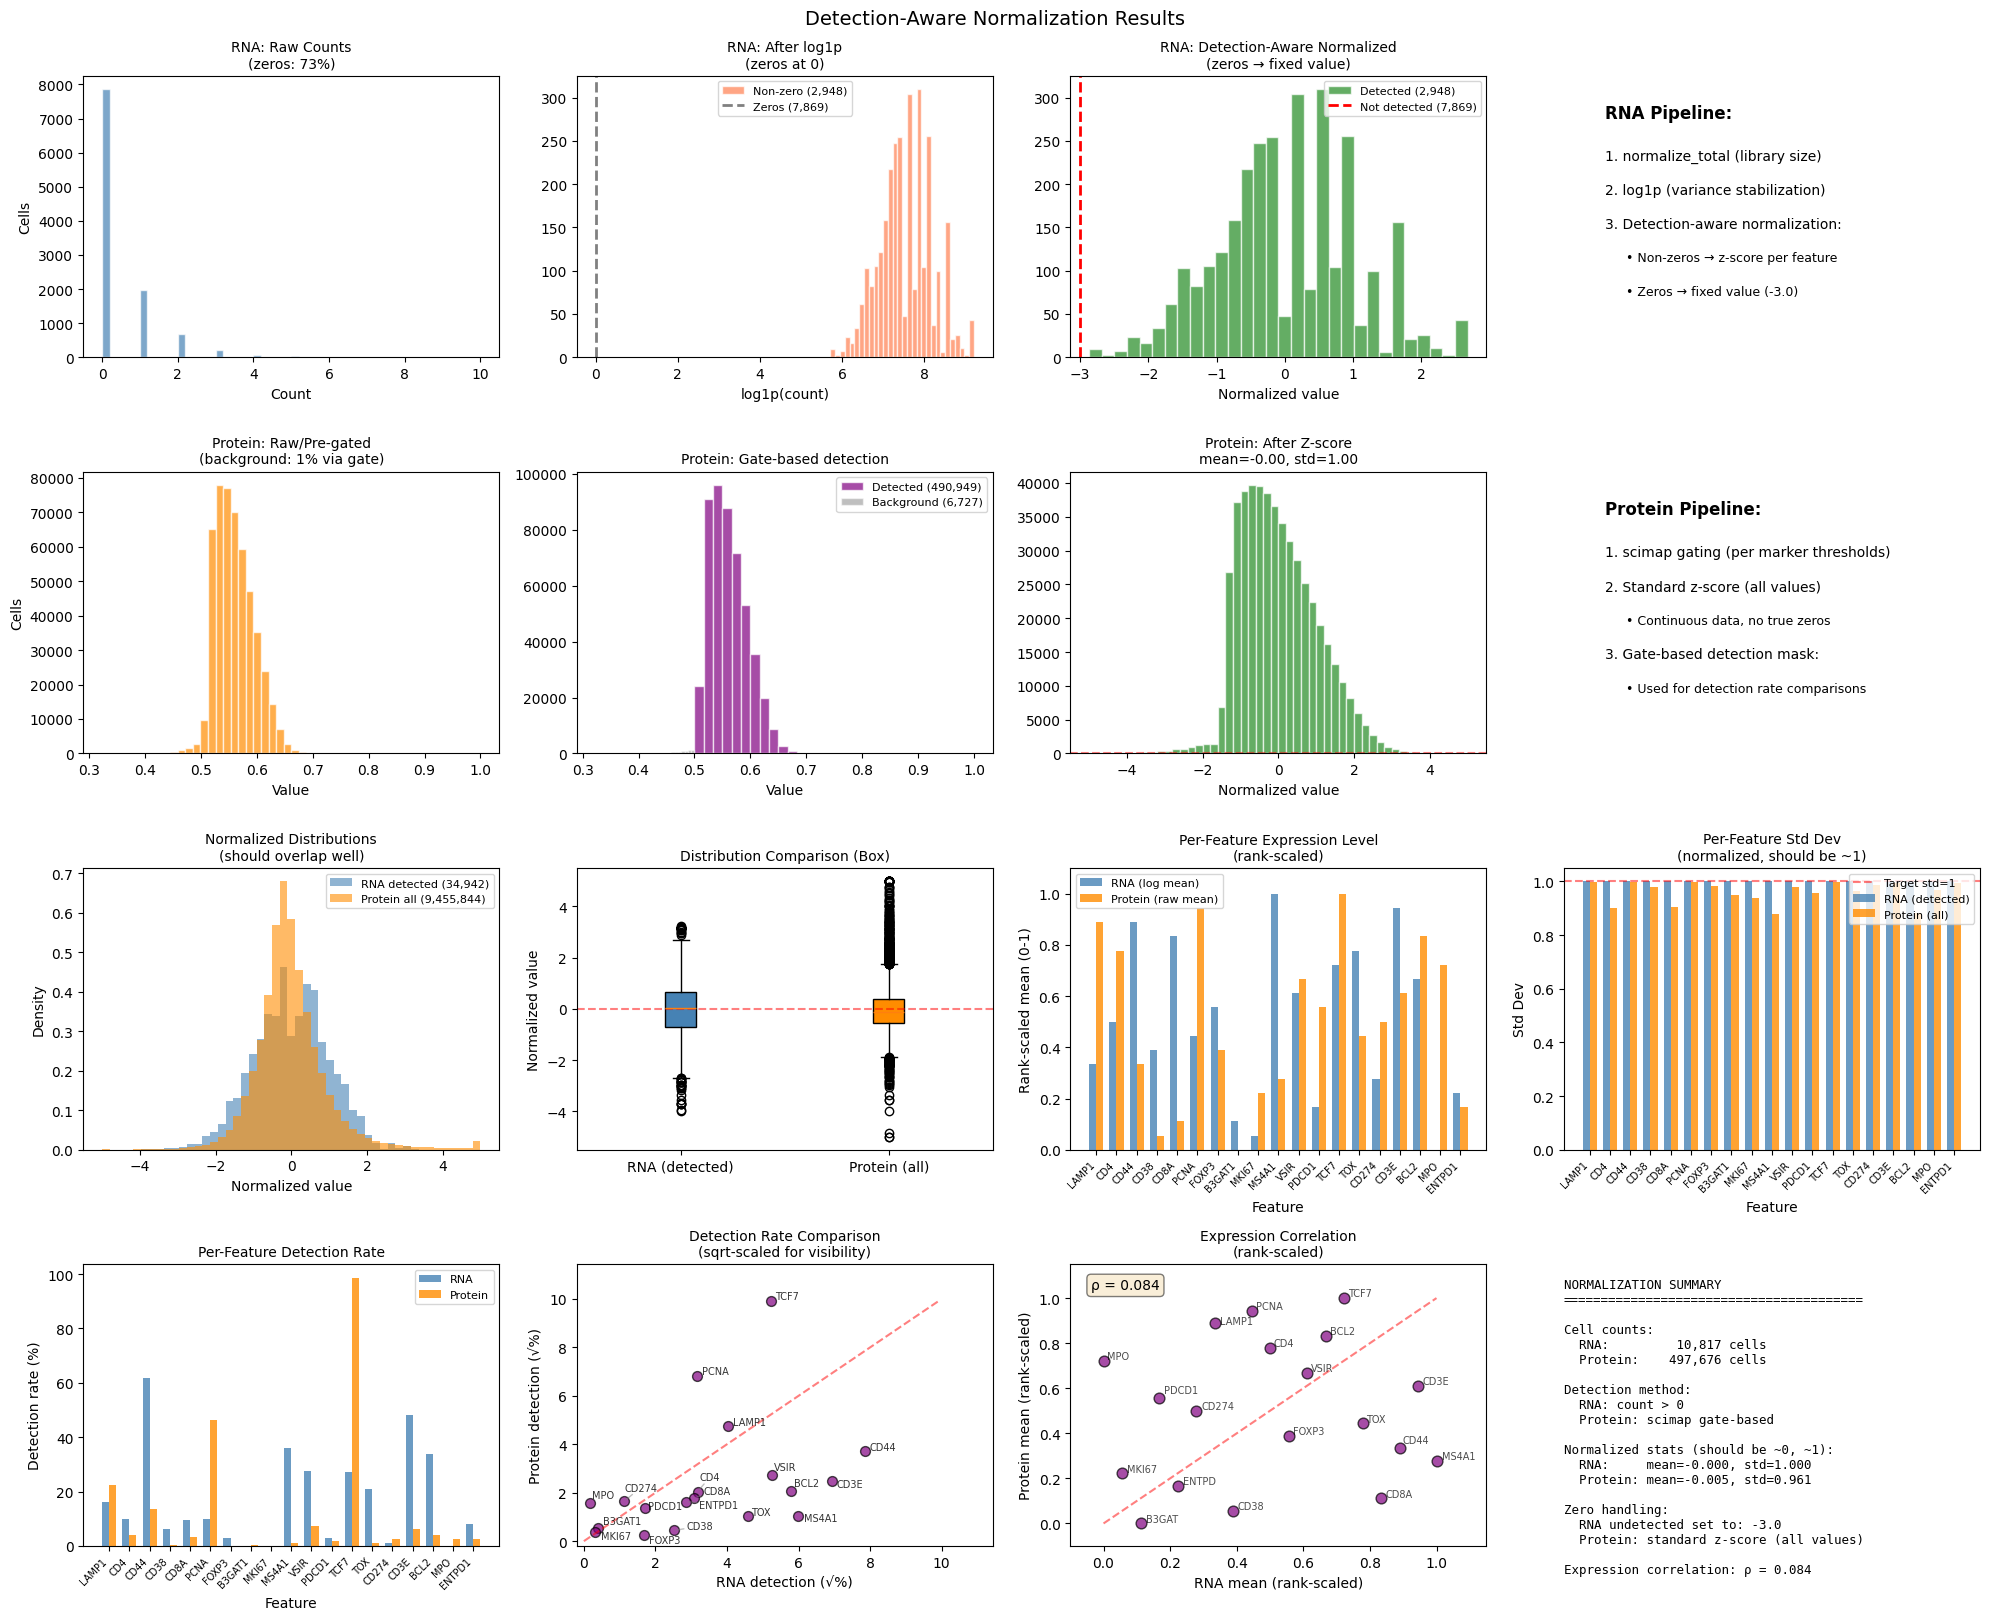


KEY INSIGHT:
RNA detection: count > 0 (sparse data)
Protein detection: scimap gate-based (continuous data)
Both normalized to ~N(0,1) for matching.

Expression correlation: Spearman ρ = 0.084 (p = 7.32e-01)


In [8]:
# Visualize DETECTION-AWARE normalization
# Updated to use 4x4 grid matching the working visualization.py

# SANITY CHECK: Detect if old cached values are being used
prot_at_minus3 = np.abs(protein_shared - (-3.0)) < 0.1
if prot_at_minus3.mean() > 0.1:
    print("="*70)
    print("WARNING: Protein data appears to have old cached values!")
    print(f"  {prot_at_minus3.mean()*100:.1f}% of values are near -3.0")
    print("  FIX: Restart kernel and re-run all cells from the beginning")
    print("="*70)
    raise RuntimeError("Please restart kernel and re-run all cells")

from scipy.stats import rankdata, spearmanr

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

feature_names = list(rna_protein_correspondence[:, 0])
protein_names = list(rna_protein_correspondence[:, 1])
n_features = rna_shared.shape[1]

# Define x_pos and width for bar charts
x_pos = np.arange(n_features)
width = 0.35

# Pick a feature with moderate expression for detailed view
detection_rates_rna = [rna_detection_mask[:, i].mean() for i in range(n_features)]
good_features = [i for i, d in enumerate(detection_rates_rna) if 0.2 < d < 0.8]
if good_features:
    best_feat_idx = good_features[len(good_features)//2]
else:
    best_feat_idx = np.argmax(detection_rates_rna)
feat_name = feature_names[best_feat_idx]
prot_name = protein_names[best_feat_idx]

# Detection rates
rna_det_rates = [rna_detection_mask[:, i].mean() * 100 for i in range(n_features)]
prot_det_rates = [protein_detection_mask[:, i].mean() * 100 for i in range(n_features)]

rna_det = rna_det_rates[best_feat_idx]
prot_det = prot_det_rates[best_feat_idx]

# Compute PRE-NORMALIZATION means for the bar chart and scatter plots
# These are meaningful values (not z-scored to 0)
rna_log_means = []
prot_raw_means = []
for i in range(n_features):
    detected = rna_detection_mask[:, i]
    if detected.sum() > 0:
        rna_log_means.append(rna_after_log[detected, i].mean())
    else:
        rna_log_means.append(0)
    prot_raw_means.append(protein_shared_raw[:, i].mean())
rna_log_means = np.array(rna_log_means)
prot_raw_means = np.array(prot_raw_means)

# Also compute POST-NORMALIZATION means/stds for QC
rna_means_norm = []
prot_means_norm = []
rna_stds_norm = []
prot_stds_norm = []
for i in range(n_features):
    rna_det_vals = rna_shared[rna_detection_mask[:, i], i]
    rna_means_norm.append(rna_det_vals.mean() if len(rna_det_vals) > 0 else 0)
    rna_stds_norm.append(rna_det_vals.std() if len(rna_det_vals) > 1 else 0)
    prot_means_norm.append(protein_shared[:, i].mean())
    prot_stds_norm.append(protein_shared[:, i].std())

print(f"Example feature: {feat_name} / {prot_name}")
print(f"  RNA detection: {rna_det:.1f}% ({int(rna_det/100 * rna_shared.shape[0]):,} cells)")
print(f"  Protein detection (gate-based): {prot_det:.1f}% ({int(prot_det/100 * protein_shared.shape[0]):,} cells)")

# ============================================================
# Row 1: RNA transformation pipeline
# ============================================================
ax = axes[0, 0]
raw_vals = rna_shared_raw[:, best_feat_idx]
ax.hist(raw_vals, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
ax.set_title(f'RNA: Raw Counts\n(zeros: {(raw_vals==0).mean()*100:.0f}%)', fontsize=10)
ax.set_xlabel('Count')
ax.set_ylabel('Cells')

ax = axes[0, 1]
log_vals = rna_after_log[:, best_feat_idx]
zeros = log_vals == 0
nonzeros = ~zeros
ax.hist(log_vals[nonzeros], bins=30, alpha=0.7, color='coral', edgecolor='white', label=f'Non-zero ({nonzeros.sum():,})')
if zeros.sum() > 0:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=2, label=f'Zeros ({zeros.sum():,})')
ax.set_title('RNA: After log1p\n(zeros at 0)', fontsize=10)
ax.set_xlabel('log1p(count)')
ax.legend(fontsize=8)

ax = axes[0, 2]
norm_vals = rna_shared[:, best_feat_idx]
nonzero_mask = norm_vals > ZERO_VALUE + 0.1
ax.hist(norm_vals[nonzero_mask], bins=30, alpha=0.7, color='forestgreen', edgecolor='white', 
        label=f'Detected ({nonzero_mask.sum():,})')
ax.axvline(x=ZERO_VALUE, color='red', linestyle='--', linewidth=2, 
           label=f'Not detected ({(~nonzero_mask).sum():,})')
ax.set_title('RNA: Detection-Aware Normalized\n(zeros → fixed value)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.legend(fontsize=8)

ax = axes[0, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'RNA Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. normalize_total (library size)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.58, '2. log1p (variance stabilization)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.46, '3. Detection-aware normalization:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.34, '• Non-zeros → z-score per feature', fontsize=9, transform=ax.transAxes)
ax.text(0.15, 0.22, f'• Zeros → fixed value ({ZERO_VALUE})', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 2: Protein transformation pipeline
# ============================================================
ax = axes[1, 0]
raw_vals_prot = protein_shared_raw[:, best_feat_idx]
is_bg = ~protein_detection_mask[:, best_feat_idx]
pct_bg = is_bg.mean() * 100
ax.hist(raw_vals_prot, bins=50, alpha=0.7, color='darkorange', edgecolor='white')
ax.set_title(f'Protein: Raw/Pre-gated\n(background: {pct_bg:.0f}% via gate)', fontsize=10)
ax.set_xlabel('Value')
ax.set_ylabel('Cells')

ax = axes[1, 1]
prot_vals = protein_shared_raw[:, best_feat_idx]
detected_prot = protein_detection_mask[:, best_feat_idx]
nondetected_prot = ~detected_prot
ax.hist(prot_vals[detected_prot], bins=30, alpha=0.7, color='purple', edgecolor='white', 
        label=f'Detected ({detected_prot.sum():,})')
if nondetected_prot.sum() > 0:
    ax.hist(prot_vals[nondetected_prot], bins=30, alpha=0.5, color='gray', edgecolor='white', 
            label=f'Background ({nondetected_prot.sum():,})')
ax.set_title('Protein: Gate-based detection', fontsize=10)
ax.set_xlabel('Value')
ax.legend(fontsize=8)

ax = axes[1, 2]
norm_vals_prot = protein_shared[:, best_feat_idx]
ax.hist(norm_vals_prot, bins=50, alpha=0.7, color='forestgreen', edgecolor='white')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title(f'Protein: After Z-score\nmean={norm_vals_prot.mean():.2f}, std={norm_vals_prot.std():.2f}', fontsize=10)
ax.set_xlabel('Normalized value')

ax = axes[1, 3]
ax.axis('off')
ax.text(0.1, 0.85, 'Protein Pipeline:', fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.1, 0.70, '1. scimap gating (per marker thresholds)', fontsize=10, transform=ax.transAxes)
ax.text(0.1, 0.58, '2. Standard z-score (all values)', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.46, '• Continuous data, no true zeros', fontsize=9, transform=ax.transAxes)
ax.text(0.1, 0.34, '3. Gate-based detection mask:', fontsize=10, transform=ax.transAxes)
ax.text(0.15, 0.22, '• Used for detection rate comparisons', fontsize=9, transform=ax.transAxes)

# ============================================================
# Row 3: Distribution comparison
# ============================================================

rna_nonzero = rna_shared[rna_detection_mask]
prot_all = protein_shared.flatten()

ax = axes[2, 0]
all_min = min(rna_nonzero.min(), prot_all.min())
all_max = max(rna_nonzero.max(), prot_all.max())
bins = np.linspace(all_min, all_max, 50)
ax.hist(rna_nonzero, bins=bins, alpha=0.6, density=True, label=f'RNA detected ({len(rna_nonzero):,})', color='steelblue')
ax.hist(prot_all, bins=bins, alpha=0.6, density=True, label=f'Protein all ({len(prot_all):,})', color='darkorange')
ax.set_title('Normalized Distributions\n(should overlap well)', fontsize=10)
ax.set_xlabel('Normalized value')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

ax = axes[2, 1]
rna_sample = rna_nonzero[::max(1, len(rna_nonzero)//5000)]
prot_sample = prot_all[::max(1, len(prot_all)//5000)]
bp = ax.boxplot([rna_sample, prot_sample], labels=['RNA (detected)', 'Protein (all)'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkorange')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Normalized value')
ax.set_title('Distribution Comparison (Box)', fontsize=10)

# Per-feature mean - USE PRE-NORMALIZATION VALUES (log for RNA, raw for protein)
# This is meaningful, unlike z-scored means which are ~0 by design
ax = axes[2, 2]

# Rank-scale for visualization (same as Expression Correlation scatter)
rna_ranks = rankdata(rna_log_means, method='average')
prot_ranks = rankdata(prot_raw_means, method='average')
rna_scaled = (rna_ranks - 1) / (n_features - 1) if n_features > 1 else np.zeros_like(rna_ranks)
prot_scaled = (prot_ranks - 1) / (n_features - 1) if n_features > 1 else np.zeros_like(prot_ranks)

ax.bar(x_pos - width/2, rna_scaled, width, label='RNA (log mean)', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_scaled, width, label='Protein (raw mean)', alpha=0.8, color='darkorange')
ax.set_xlabel('Feature')
ax.set_ylabel('Rank-scaled mean (0-1)')
ax.set_title('Per-Feature Expression Level\n(rank-scaled)', fontsize=10)
ax.legend(fontsize=8, loc='upper left')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)
ax.set_ylim(0, 1.1)

# Per-feature std of NORMALIZED values (should be ~1 for QC)
ax = axes[2, 3]
ax.bar(x_pos - width/2, rna_stds_norm, width, label='RNA (detected)', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_stds_norm, width, label='Protein (all)', alpha=0.8, color='darkorange')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Target std=1')
ax.set_xlabel('Feature')
ax.set_ylabel('Std Dev')
ax.set_title('Per-Feature Std Dev\n(normalized, should be ~1)', fontsize=10)
ax.legend(fontsize=8, loc='upper right')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)

# ============================================================
# Row 4: Detection rates and summary
# ============================================================

ax = axes[3, 0]
ax.bar(x_pos - width/2, rna_det_rates, width, label='RNA', alpha=0.8, color='steelblue')
ax.bar(x_pos + width/2, prot_det_rates, width, label='Protein', alpha=0.8, color='darkorange')
ax.set_xlabel('Feature')
ax.set_ylabel('Detection rate (%)')
ax.set_title('Per-Feature Detection Rate', fontsize=10)
ax.legend(fontsize=8, loc='upper right')
ax.set_xticks(x_pos)
ax.set_xticklabels([f[:6] for f in feature_names], rotation=45, ha='right', fontsize=7)

# Detection rate scatter - sqrt scaling for better spread
# Use adjustText to prevent label overlap
from adjustText import adjust_text

ax = axes[3, 1]
rna_det_sqrt = np.sqrt(rna_det_rates)
prot_det_sqrt = np.sqrt(prot_det_rates)
ax.scatter(rna_det_sqrt, prot_det_sqrt, s=50, alpha=0.7, c='purple', edgecolors='black')

# Create text objects for adjustText
det_texts = []
for i, fname in enumerate(feature_names):
    det_texts.append(ax.text(rna_det_sqrt[i], prot_det_sqrt[i], fname[:6], fontsize=7, alpha=0.8))

max_val = max(max(rna_det_sqrt), max(prot_det_sqrt))
ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
ax.set_xlabel('RNA detection (√%)')
ax.set_ylabel('Protein detection (√%)')
ax.set_title('Detection Rate Comparison\n(sqrt-scaled for visibility)', fontsize=10)
ax.set_xlim(-0.2, max_val + 1.5)
ax.set_ylim(-0.2, max_val + 1.5)

# Adjust text positions to avoid overlap
adjust_text(det_texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Expression Correlation scatter (rank-scaled)
ax = axes[3, 2]
ax.scatter(rna_scaled, prot_scaled, s=60, alpha=0.7, c='purple', edgecolors='black')

# Create text objects for adjustText
expr_texts = []
for i, fname in enumerate(feature_names):
    expr_texts.append(ax.text(rna_scaled[i], prot_scaled[i], fname[:5], fontsize=7, alpha=0.7))

ax.set_xlim(-0.1, 1.15)
ax.set_ylim(-0.1, 1.15)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='y=x')
ax.set_xlabel('RNA mean (rank-scaled)')
ax.set_ylabel('Protein mean (rank-scaled)')
ax.set_title('Expression Correlation\n(rank-scaled)', fontsize=10)
spearman_corr, spearman_p = spearmanr(rna_log_means, prot_raw_means)
ax.text(0.05, 0.95, f'ρ = {spearman_corr:.3f}', transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Adjust text positions to avoid overlap
adjust_text(expr_texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Summary
ax = axes[3, 3]
ax.axis('off')
summary = f"""NORMALIZATION SUMMARY
{"="*40}

Cell counts:
  RNA:     {rna_shared.shape[0]:>10,} cells
  Protein: {protein_shared.shape[0]:>10,} cells

Detection method:
  RNA: count > 0
  Protein: scimap gate-based

Normalized stats (should be ~0, ~1):
  RNA:     mean={np.mean(rna_means_norm):.3f}, std={np.mean(rna_stds_norm):.3f}
  Protein: mean={np.mean(prot_means_norm):.3f}, std={np.mean(prot_stds_norm):.3f}

Zero handling:
  RNA undetected set to: {ZERO_VALUE}
  Protein: standard z-score (all values)

Expression correlation: ρ = {spearman_corr:.3f}
"""
ax.text(0.0, 0.95, summary, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.suptitle('Detection-Aware Normalization Results', fontsize=14, y=1.01)
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("RNA detection: count > 0 (sparse data)")
print("Protein detection: scimap gate-based (continuous data)")
print("Both normalized to ~N(0,1) for matching.")
print(f"\nExpression correlation: Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.2e})")


In [9]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]
    # Update correspondence
    rna_protein_correspondence = rna_protein_correspondence[valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")


Final shared arrays:
  rna_shared: (10817, 19)
  protein_shared: (497676, 19)


In [10]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Use gate-based detection from cell 10
# protein_detection_mask and rna_detection_mask were created during normalization

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    # Use detection masks (gate-based for protein, non-zero for RNA)
    rna_pct_expressing = rna_detection_mask[:, i].mean() * 100
    prot_pct_expressing = protein_detection_mask[:, i].mean() * 100
    
    feature_stats.append({
        'RNA name': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate (GATE-BASED): {avg_prot_detection:.1f}% of cells")

# Warning for sparse features
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  NOTE: {len(rare_features)} features detected in <10% of RNA cells")
    print("  These provide weaker signal for matching.")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA name Protein  RNA_%_expressing  Prot_%_expressing
     MPO     MPO          0.027734           2.476310
   MKI67    Ki67          0.101692           0.134827
  B3GAT1    CD57          0.147915           0.309237
   CD274   PD-L1          1.257280           2.693921
   FOXP3   FOXP3          2.865859           0.059276
   PDCD1    PD-1          2.930572           1.821064
    CD38    CD38          6.295646           0.194504
  ENTPD1    CD39          8.153832           2.678248
    CD8A     CD8          9.485070           3.228205
    PCNA    PCNA         10.067486          46.412124
     CD4     CD4         10.095220           4.185454
   LAMP1  CD107a         16.298419          22.415588
     TOX     TOX         20.976241           1.047871
    TCF7   TCF-1         27.253397          98.648317
    VSIR   VISTA         27.724878           7.467107
    BCL2   Bcl-2         33.641490       

In [11]:
# Protein active - use all markers EXCEPT excluded ones
# Must match exclusions from shared feature cell for consistency
protein_markers_active = [m for m in protein_adata.var_names if m not in EXCLUDED_MARKERS]
protein_adata_active = protein_adata[:, protein_markers_active].copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)

print(f"Protein active: {protein_adata_active.shape}")
print(f"  Excluded {len(EXCLUDED_MARKERS)} markers: {len(protein_adata.var_names)} -> {len(protein_markers_active)}")

Protein active: (497676, 19)
  Excluded 20 markers: 19 -> 19


In [12]:
# Extract numpy arrays
rna_active = rna_adata.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (10817, 20937)
  protein_active: (497676, 19)


In [13]:
# CRITICAL VALIDATION: Check array dimensions match
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     10817
RNA active cells:     10817
Protein shared cells: 497676
Protein active cells: 497676

All dimensions validated!

Integrating 10817 RNA cells with 497676 protein cells
Using 19 shared features for initialization


In [14]:
# Save checkpoint for cross-modal integration
# This allows skipping the MARIO section and going directly to MaxFuse

checkpoint_dir = '../results/2_integration'
os.makedirs(checkpoint_dir, exist_ok=True)

# Save arrays needed for MaxFuse
np.save(f'{checkpoint_dir}/checkpoint_rna_shared.npy', rna_shared)
np.save(f'{checkpoint_dir}/checkpoint_protein_shared.npy', protein_shared)
np.save(f'{checkpoint_dir}/checkpoint_rna_active.npy', rna_active)
np.save(f'{checkpoint_dir}/checkpoint_protein_active.npy', protein_active)

# Save correspondence
correspondence_checkpoint = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_checkpoint.to_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv', index=False)

print(f'Checkpoint saved to {checkpoint_dir}/')
print(f'  - checkpoint_rna_shared.npy: {rna_shared.shape}')
print(f'  - checkpoint_protein_shared.npy: {protein_shared.shape}')
print(f'  - checkpoint_rna_active.npy: {rna_active.shape}')
print(f'  - checkpoint_protein_active.npy: {protein_active.shape}')
print(f'  - checkpoint_correspondence.csv')
print(f'\nYou can now skip to MaxFuse Integration (Step 7) if desired.')

Checkpoint saved to ../results/2_integration/
  - checkpoint_rna_shared.npy: (10817, 19)
  - checkpoint_protein_shared.npy: (497676, 19)
  - checkpoint_rna_active.npy: (10817, 20937)
  - checkpoint_protein_active.npy: (497676, 19)
  - checkpoint_correspondence.csv

You can now skip to MaxFuse Integration (Step 7) if desired.


---
# MARIO Integration (Optional - Same-Modality Data Only)

**IMPORTANT**: MARIO is designed for **same-modality integration** (e.g., protein-protein).

## When to Use MARIO
- Both datasets measure the **same biological quantity** (e.g., CITE-seq vs CyTOF)
- Shared features are the **same measurements** by different technologies
- Values should be **correlated but not identical** between modalities

## When to Skip MARIO
- **Cross-modal integration** (e.g., RNA-seq vs protein/CODEX) → **Skip to MaxFuse**
- Shared features represent **different biological measurements** (mRNA vs protein)
- Canonical correlations are all ~1.0 (indicates data incompatibility)

## Current Data Type
This notebook integrates **RNA-seq with CODEX protein data** - a cross-modal scenario.

**Recommendation**: Skip this section and proceed to **MaxFuse Integration (Step 7)**.

---

If you still want to run MARIO (e.g., for comparison or same-modality data), continue below.

## Step 5: MARIO - Matchability Test (Pre-Integration Diagnostic)

Before running integration, we test whether the two datasets have meaningful correspondence.
MARIO uses random sign flips to create a null distribution and computes p-values.

- **Low p-value** (< 0.05): Datasets are matchable
- **High p-value** (> 0.05): No significant correspondence detected

### Data Validation

Check for and handle NaN/Inf values that may result from normalization of sparse features.

In [15]:
# # Check and handle NaN/Inf values before MARIO
# # Detection-aware normalization can produce NaN for problematic features

# print("Checking for NaN/Inf values in shared arrays...")
# print(f"  rna_shared: NaN={np.isnan(rna_shared).sum()}, Inf={np.isinf(rna_shared).sum()}")
# print(f"  protein_shared: NaN={np.isnan(protein_shared).sum()}, Inf={np.isinf(protein_shared).sum()}")

# # Replace NaN/Inf with 0 (these are likely failed normalizations for sparse features)
# if np.isnan(rna_shared).any() or np.isinf(rna_shared).any():
#     print("\nCleaning rna_shared...")
#     rna_shared = np.nan_to_num(rna_shared, nan=0.0, posinf=0.0, neginf=0.0)
    
# if np.isnan(protein_shared).any() or np.isinf(protein_shared).any():
#     print("Cleaning protein_shared...")
#     protein_shared = np.nan_to_num(protein_shared, nan=0.0, posinf=0.0, neginf=0.0)

# # Also check active arrays
# print(f"\n  rna_active: NaN={np.isnan(rna_active).sum()}, Inf={np.isinf(rna_active).sum()}")
# print(f"  protein_active: NaN={np.isnan(protein_active).sum()}, Inf={np.isinf(protein_active).sum()}")

# if np.isnan(rna_active).any() or np.isinf(rna_active).any():
#     print("\nCleaning rna_active...")
#     rna_active = np.nan_to_num(rna_active, nan=0.0, posinf=0.0, neginf=0.0)
    
# if np.isnan(protein_active).any() or np.isinf(protein_active).any():
#     print("Cleaning protein_active...")
#     protein_active = np.nan_to_num(protein_active, nan=0.0, posinf=0.0, neginf=0.0)

# print("\nArrays cleaned and ready for integration.")

In [16]:
# # Subsample for MARIO (MARIO requires n1 <= n2, and for speed we subsample)
# np.random.seed(42)

# # MARIO needs RNA (smaller) to be df1 and Protein (larger) to be df2
# n_rna_subsample = min(2000, rna_shared.shape[0])
# n_prot_subsample = min(10000, protein_shared.shape[0])

# rna_idx_subsample = np.random.choice(rna_shared.shape[0], n_rna_subsample, replace=False)
# prot_idx_subsample = np.random.choice(protein_shared.shape[0], n_prot_subsample, replace=False)

# # Create DataFrames with overlapping column names (required by MARIO)
# shared_feature_names = [f"feat_{i}" for i in range(rna_shared.shape[1])]

# # Extract subsamples and ensure no NaN values
# rna_subsample = rna_shared[rna_idx_subsample].copy()
# prot_subsample = protein_shared[prot_idx_subsample].copy()

# # Final NaN check on subsamples
# rna_subsample = np.nan_to_num(rna_subsample, nan=0.0, posinf=0.0, neginf=0.0)
# prot_subsample = np.nan_to_num(prot_subsample, nan=0.0, posinf=0.0, neginf=0.0)

# rna_df_mario = pd.DataFrame(rna_subsample, columns=shared_feature_names)
# prot_df_mario = pd.DataFrame(prot_subsample, columns=shared_feature_names)

# print(f"MARIO subsample sizes:")
# print(f"  RNA: {rna_df_mario.shape}")
# print(f"  Protein: {prot_df_mario.shape}")
# print(f"  NaN in RNA df: {rna_df_mario.isna().sum().sum()}")
# print(f"  NaN in Protein df: {prot_df_mario.isna().sum().sum()}")

In [17]:
# # Initialize MARIO
# mario = Mario(rna_df_mario, prot_df_mario, normalization=True)

# # Specify matching parameters
# # n_matched_per_cell: how many protein cells to match with each RNA cell
# n_matched = max(1, n_prot_subsample // n_rna_subsample)
# mario.specify_matching_params(n_matched_per_cell=n_matched)

# print(f"Matching {n_matched} protein cells per RNA cell")

In [18]:
# # Compute distance using overlapping features
# n_ovlp_components = min(15, rna_shared.shape[1] - 1)
# dist_ovlp, singular_vals = mario.compute_dist_ovlp(n_components=n_ovlp_components)

# print(f"Distance matrix shape: {dist_ovlp.shape}")
# print(f"Singular values: {singular_vals[:5]}...")

# # Plot singular values
# plt.figure(figsize=(8, 4))
# plt.plot(singular_vals, 'bo-')
# plt.xlabel('Component')
# plt.ylabel('Singular Value')
# plt.title('MARIO: Singular Values of Stacked Overlap Features')
# plt.show()

In [19]:
# # Initial matching using overlap features
# print("Finding initial matching using overlap features...")
# matching_ovlp = mario.match_cells('ovlp', sparsity=None, mode='auto')

# Count matched cells
# n_matched_cells = sum(1 for m in matching_ovlp if len(m) > 0)
# print(f"Matched {n_matched_cells}/{len(matching_ovlp)} RNA cells")

In [20]:
# # Add active features (all HVGs) for refined matching
# # For MARIO, we need DataFrames with:
# # - Overlapping columns (shared features) with same names
# # - Non-overlapping columns (active features) with different names

# # RNA: shared features + active features
# rna_active_subsample = rna_active[rna_idx_subsample].copy()
# rna_active_subsample = np.nan_to_num(rna_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
# rna_active_names = [f"rna_feat_{i}" for i in range(rna_active_subsample.shape[1])]

# rna_df_full = pd.DataFrame(
#     np.hstack([rna_subsample, rna_active_subsample]),
#     columns=shared_feature_names + rna_active_names
# )

# # Protein: shared features + active features
# prot_active_subsample = protein_active[prot_idx_subsample].copy()
# prot_active_subsample = np.nan_to_num(prot_active_subsample, nan=0.0, posinf=0.0, neginf=0.0)
# prot_active_names = [f"prot_feat_{i}" for i in range(prot_active_subsample.shape[1])]

# prot_df_full = pd.DataFrame(
#     np.hstack([prot_subsample, prot_active_subsample]),
#     columns=shared_feature_names + prot_active_names
# )

# print(f"Full DataFrames for MARIO:")
# print(f"  RNA: {rna_df_full.shape} ({len(shared_feature_names)} shared + {len(rna_active_names)} active)")
# print(f"  Protein: {prot_df_full.shape} ({len(shared_feature_names)} shared + {len(prot_active_names)} active)")
# print(f"  NaN check - RNA: {rna_df_full.isna().sum().sum()}, Protein: {prot_df_full.isna().sum().sum()}")

In [21]:
# # Create new MARIO object with full features
# mario_full = Mario(rna_df_full, prot_df_full, normalization=False)
# mario_full.specify_matching_params(n_matched_per_cell=n_matched)

# # Compute distance using overlap features
# _ = mario_full.compute_dist_ovlp(n_components=n_ovlp_components)

# # Initial matching
# _ = mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# # Compute distance using ALL features (CCA refinement)
# # NOTE: Use conservative number of CCA components.
# # With few protein features relative to RNA features and matched samples,
# # CCA can find trivially perfect correlations if given too many components.
# # Rule of thumb: use min(n_shared - 1, sqrt(n_prot_active))
# n_prot_active = prot_df_full.shape[1] - len(shared_feature_names)
# n_cca_components = min(
#     len(shared_feature_names) - 1,  # No more than shared features
#     int(np.sqrt(n_prot_active)) + 1,  # Conservative based on protein features
#     8  # Hard cap for this data
# )
# n_cca_components = max(3, n_cca_components)  # At least 3 components
# print(f"Using {n_cca_components} CCA components")
# print(f"  (shared features: {len(shared_feature_names)}, protein active: {n_prot_active})")

# dist_all, cancor = mario_full.compute_dist_all('ovlp', n_components=n_cca_components)

# # Interpret canonical correlations
# print(f"\nCanonical correlations: {np.round(cancor, 4)}")

# if np.allclose(cancor, 1.0, atol=0.01):
#     print("\nNOTE: Canonical correlations are very high (~1.0).")
#     print("This is common when protein features are few relative to matched samples.")
#     print("The CCA can perfectly align matched pairs in this low-dimensional space.")
#     print("Matching quality depends on how well CCA generalizes to unmatched cells.")
# elif np.mean(cancor) > 0.7:
#     print("\nGood: High canonical correlations indicate strong alignment.")
# else:
#     print("\nNote: Moderate correlations - may indicate weaker cross-modal alignment.")

# # Plot canonical correlations
# plt.figure(figsize=(8, 4))
# plt.bar(range(len(cancor)), cancor)
# plt.xlabel('CCA Component')
# plt.ylabel('Canonical Correlation')
# plt.title('MARIO: Canonical Correlations')
# plt.ylim(0, 1.1)
# plt.axhline(y=0.7, color="orange", linestyle="--", alpha=0.5, label="Good threshold")
# plt.legend()
# plt.show()

In [22]:
# # Match using all features
# matching_all = mario_full.match_cells('all', sparsity=None, mode='auto')

# n_matched_all = sum(1 for m in matching_all if len(m) > 0)
# print(f"Matched {n_matched_all}/{len(matching_all)} RNA cells using all features")

In [23]:
# # DIAGNOSTIC: Check canonical correlations before matchability test

# print("="*60)
# print("MATCHABILITY DIAGNOSTIC")
# print("="*60)

# # Check the canonical correlations from the existing matching
# print("\n1. OBSERVED CANONICAL CORRELATIONS:")
# print(f"   From compute_dist_all (stored): {cancor[:5] if 'cancor' in dir() else 'Not computed'}")

# # Check data properties
# print("\n2. DATA PROPERTIES:")
# print(f"   mario_full.df1 shape: {mario_full.df1.shape}")
# print(f"   mario_full.df2 shape: {mario_full.df2.shape}")
# print(f"   Overlap features: {len(mario_full.ovlp_features)}")

# # Check for zero-variance features
# df1_std = mario_full.df1.std()
# df2_std = mario_full.df2.std()
# print(f"\n   df1 zero-variance features: {(df1_std < 1e-10).sum()}")
# print(f"   df2 zero-variance features: {(df2_std < 1e-10).sum()}")

# # Check data scale
# print("\n3. DATA SCALE:")
# print(f"   df1 mean: {mario_full.df1.values.mean():.4f}, std: {mario_full.df1.values.std():.4f}")
# print(f"   df2 mean: {mario_full.df2.values.mean():.4f}, std: {mario_full.df2.values.std():.4f}")

# # CHECK MATCHING - this is critical
# print("\n4. MATCHING STATISTICS:")
# n_matched_ovlp = sum(1 for m in mario_full.matching['ovlp'] if len(m) > 0)
# n_matched_all = sum(1 for m in mario_full.matching['all'] if len(m) > 0)
# print(f"   Cells matched (overlap): {n_matched_ovlp} / {mario_full.n1}")
# print(f"   Cells matched (all):     {n_matched_all} / {mario_full.n1}")

# # Check the aligned data dimensions for CCA
# from mario import embed
# X_aligned = []
# Y_aligned = []
# for ii in range(mario_full.n1):
#     if len(mario_full.matching['ovlp'][ii]) > 0:
#         X_aligned.append(mario_full.df1.iloc[ii, :].values)
#         Y_aligned.append(mario_full.df2.iloc[mario_full.matching['ovlp'][ii]].mean(axis=0).values)

# X_aligned = np.array(X_aligned)
# Y_aligned = np.array(Y_aligned)
# print(f"\n5. CCA INPUT DIMENSIONS:")
# print(f"   X (RNA) aligned: {X_aligned.shape}")
# print(f"   Y (Protein) aligned: {Y_aligned.shape}")
# print(f"   Ratio features/samples (RNA): {X_aligned.shape[1]/X_aligned.shape[0]:.1f}")

# # THE PROBLEM: CCA with features >> samples gives trivial perfect correlations!
# if X_aligned.shape[1] > X_aligned.shape[0]:
#     print("\n   ⚠️  WARNING: More features than samples!")
#     print("   CCA will overfit and give meaningless correlations of 1.0")
#     print("   This is why matchability test returns p=1")

# # Test CCA with ONLY overlap features
# print("\n6. CCA WITH OVERLAP FEATURES ONLY:")
# X_ovlp = mario_full.df1[mario_full.ovlp_features].iloc[[i for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0]].values
# Y_ovlp = np.array([mario_full.df2[mario_full.ovlp_features].iloc[mario_full.matching['ovlp'][i]].mean(axis=0).values 
#                    for i in range(mario_full.n1) if len(mario_full.matching['ovlp'][i]) > 0])
# print(f"   X_ovlp shape: {X_ovlp.shape}")
# print(f"   Y_ovlp shape: {Y_ovlp.shape}")

# try:
#     n_comp = min(5, X_ovlp.shape[1]-1, X_ovlp.shape[0]-1)
#     cancor_ovlp_only, _ = embed.get_cancor(X_ovlp, Y_ovlp, n_components=n_comp)
#     print(f"   Canonical correlations (overlap only): {cancor_ovlp_only}")
#     print(f"   Mean: {np.mean(cancor_ovlp_only):.4f}")
# except Exception as e:
#     print(f"   Error: {e}")

# print("\n" + "="*60)


In [24]:
# # Run matchability test
# print("=" * 60)
# print("MARIO MATCHABILITY TEST")
# print("=" * 60)
# print("\nRunning statistical test for dataset matchability...")
# print("(This uses random sign flips to create null distribution)")
# print()

# # CRITICAL FIX: Clean NaN/Inf values in MARIO dataframes before matchability test
# # The matchability test internally uses CCA which cannot handle NaN values
# print("Cleaning MARIO dataframes for CCA compatibility...")

# # Clean df1 (RNA) - aggressive column-by-column approach
# mario_full.df1 = mario_full.df1.copy()
# for col in mario_full.df1.columns:
#     mario_full.df1[col] = np.nan_to_num(mario_full.df1[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# # Clean df2 (Protein) - aggressive column-by-column approach
# mario_full.df2 = mario_full.df2.copy()
# for col in mario_full.df2.columns:
#     mario_full.df2[col] = np.nan_to_num(mario_full.df2[col].values, nan=0.0, posinf=0.0, neginf=0.0)

# # Verify no NaN/Inf remain
# df1_clean = not (np.isnan(mario_full.df1.values).any() or np.isinf(mario_full.df1.values).any())
# df2_clean = not (np.isnan(mario_full.df2.values).any() or np.isinf(mario_full.df2.values).any())
# print(f"  df1 clean: {df1_clean} (NaN: {np.isnan(mario_full.df1.values).sum()}, Inf: {np.isinf(mario_full.df1.values).sum()})")
# print(f"  df2 clean: {df2_clean} (NaN: {np.isnan(mario_full.df2.values).sum()}, Inf: {np.isinf(mario_full.df2.values).sum()})")
# assert df1_clean and df2_clean, "Failed to clean NaN/Inf values"

# # Ensure both initial (ovlp) and refined (all) matching are complete
# print("Verifying initial and refined matching are complete...")

# # Check if matching has been done, if not redo it
# if not hasattr(mario_full, 'matching_ovlp') or mario_full.matching_ovlp is None:
#     print("  Re-running initial matching (overlap features)...")
#     mario_full.match_cells('ovlp', sparsity=None, mode='auto')

# if not hasattr(mario_full, 'matching_all') or mario_full.matching_all is None:
#     print("  Re-running refined matching (all features)...")
#     mario_full.match_cells('all', sparsity=None, mode='auto')

# print("  Both matchings confirmed. Proceeding with matchability test...\n")

# # Note: This can take a few minutes
# # Reduce n_sim if it takes too long
# pval_ovlp, pval_all = mario_full.matchable(
#     n_sim=10,           # Number of simulations (increase for more accuracy)
#     top_k=5,            # Use top-k canonical correlations
#     flip_prob=0.3,      # Probability of sign flip
#     subsample_prop=1,   # Subsample for speed
#     verbose=True
# )

# print(f"\n{'='*60}")
# print("MATCHABILITY TEST RESULTS")
# print("="*60)
# print(f"P-value (overlap features only): {pval_ovlp:.4f}")
# print(f"P-value (all features):          {pval_all:.4f}")
# print()

# if pval_ovlp < 0.05 or pval_all < 0.05:
#     print("RESULT: Datasets appear to be MATCHABLE (p < 0.05)")
#     print("  The correspondence between modalities is statistically significant.")
# else:
#     print("RESULT: Datasets may NOT be well-matched (p >= 0.05)")
#     print("  Proceed with caution - results may be unreliable.")



## Step 6: MARIO - Interpolation (Optimal Weight Search)

MARIO searches for the optimal weight between:
- Distance from **overlap features only**
- Distance from **all features** (via CCA)

The optimal weight is selected based on canonical correlations.

In [25]:
# # Run interpolation to find optimal weight
# print("Searching for optimal interpolation weight...")
# print("(Testing weights from 0 to 1)")
# print()

# best_wt, best_matching = mario_full.interpolate(
#     n_wts=10,     # Number of weights to try
#     top_k=5,      # Use top-k canonical correlations to evaluate
#     verbose=True
# )

# print(f"\nOptimal weight: {best_wt:.2f}")
# print(f"  (0 = use only overlap features, 1 = use only CCA features)")

# n_matched_best = sum(1 for m in best_matching if len(m) > 0)
# print(f"\nMatched {n_matched_best}/{len(best_matching)} RNA cells with optimal weight")

In [26]:
# # Filter bad matches using joint regularized clustering
# print("\nFiltering bad matches using joint regularized clustering...")

# n_clusters_filter = min(15, n_rna_subsample // 50)  # Aim for ~50 cells per cluster
# n_clusters_filter = max(5, n_clusters_filter)

# filtered_matching = mario_full.filter_bad_matches(
#     matching='wted',           # Use the interpolated matching
#     n_clusters=n_clusters_filter,
#     n_components=min(15, n_cca_components),
#     bad_prop=0.1,              # Remove ~10% of worst matches
#     max_iter=30,
#     verbose=True
# )

# n_matched_filtered = sum(1 for m in filtered_matching if len(m) > 0)
# print(f"\nAfter filtering: {n_matched_filtered}/{len(filtered_matching)} RNA cells matched")
# print(f"Removed {n_matched_best - n_matched_filtered} bad matches")

In [27]:
# # Optional: KNN matching for softer assignments
# knn_matching = mario_full.knn_matching(dist_mat='wted', k=5)

# print(f"KNN matching: each RNA cell matched to {5} nearest protein cells")

In [28]:
# # Compute CCA embedding for visualization
# from mario import embed

# # Align the datasets using the filtered matching
# X_aligned = []
# Y_aligned = []
# matched_rna_indices_mario = []
# matched_prot_indices_mario = []

# for i, matches in enumerate(filtered_matching):
#     if len(matches) > 0:
#         X_aligned.append(rna_df_full.iloc[i].values)
#         # Average the matched protein cells
#         Y_aligned.append(prot_df_full.iloc[matches].mean(axis=0).values)
#         matched_rna_indices_mario.append(rna_idx_subsample[i])
#         matched_prot_indices_mario.append(prot_idx_subsample[matches[0]])  # Take first match

# X_aligned = np.array(X_aligned)
# Y_aligned = np.array(Y_aligned)

# print(f"Aligned arrays: RNA {X_aligned.shape}, Protein {Y_aligned.shape}")

# # Fit CCA for embedding
# embed_dim = min(20, X_aligned.shape[1], Y_aligned.shape[1])
# cancor_embed, cca = embed.get_cancor(X_aligned, Y_aligned, n_components=embed_dim)

# # Get CCA scores
# rna_cca_mario, prot_cca_mario = cca.transform(X_aligned, Y_aligned)

# print(f"MARIO CCA embedding: {rna_cca_mario.shape}")

In [29]:
# # Visualize MARIO results
# from sklearn.manifold import TSNE

# # Combine embeddings
# combined_mario = np.vstack([rna_cca_mario, prot_cca_mario])
# labels_mario = ['RNA'] * len(rna_cca_mario) + ['Protein'] * len(prot_cca_mario)

# # Run t-SNE (faster than UMAP for small datasets)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# embedding_2d = tsne.fit_transform(combined_mario[:, :10])  # Use first 10 CCA components

# # Plot
# plt.figure(figsize=(10, 8))
# for label in ['RNA', 'Protein']:
#     mask = np.array(labels_mario) == label
#     plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1], 
#                 label=label, alpha=0.5, s=10)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('MARIO: Joint Embedding (t-SNE of CCA scores)')
# plt.legend()
# plt.show()

---
# MaxFuse Integration (Recommended for Cross-Modal Data)

MaxFuse is specifically designed for **cross-modal integration** with:
- **Weak linkage**: Few or uninformative shared features
- **Different modalities**: RNA-seq, CODEX/protein, ATAC-seq, etc.
- **Scalable architecture**: Batch processing with pivot propagation

## Key Features
1. **Graph-based smoothing**: Reduces noise before matching
2. **Iterative CCA refinement**: Improves alignment quality
3. **Pivot propagation**: Scales to large datasets

---

In [30]:
# Load checkpoint data if MARIO section was skipped
# This cell is idempotent - safe to run even if data already loaded

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from maxfuse import Fusor

checkpoint_dir = '../results/2_integration'

# Check if we need to load from checkpoint
need_checkpoint = False
try:
    # Check if required variables exist and have data
    _ = rna_shared.shape
    _ = protein_shared.shape
    _ = rna_active.shape
    _ = protein_active.shape
    print('Data already loaded - using existing arrays.')
except NameError:
    need_checkpoint = True
    print('Data not found - loading from checkpoint...')

if need_checkpoint:
    # Load arrays from checkpoint
    rna_shared = np.load(f'{checkpoint_dir}/checkpoint_rna_shared.npy')
    protein_shared = np.load(f'{checkpoint_dir}/checkpoint_protein_shared.npy')
    rna_active = np.load(f'{checkpoint_dir}/checkpoint_rna_active.npy')
    protein_active = np.load(f'{checkpoint_dir}/checkpoint_protein_active.npy')
    
    # Load correspondence
    correspondence_df = pd.read_csv(f'{checkpoint_dir}/checkpoint_correspondence.csv')
    rna_protein_correspondence = correspondence_df.values
    
    print(f'Loaded from checkpoint:')
    print(f'  rna_shared: {rna_shared.shape}')
    print(f'  protein_shared: {protein_shared.shape}')
    print(f'  rna_active: {rna_active.shape}')
    print(f'  protein_active: {protein_active.shape}')


Data already loaded - using existing arrays.


PRE-FILTERING: Non-immune cells + marker-specific outliers

--- Filter 1: Marker-specific z-score thresholds ---
  MPO: 9,136 cells below z=-2.5 (1.8%)

  Total removed by marker filter: 9,136

--- Filter 2: Non-immune Pancreas cells ---
  Immune markers available: []
  pLN immune score: median=30.58, 25th pct=22.72
  Pancreas immune score: median=-1.29
  Threshold (pLN 25th pct): 22.72

  Pancreas cells: 473,404 → 4,222 (469,182 removed)
  pLN cells: 15,136 (all kept)

FILTERING SUMMARY
  Original cells:        497,676
  After marker filter:   488,540 (-9,136)
  After tissue filter:   19,358 (-469,182)
  Total removed:         478,318

Final arrays:
  protein_shared: (19358, 19)
  protein_active: (19358, 19)
  protein_adata: (19358, 19)


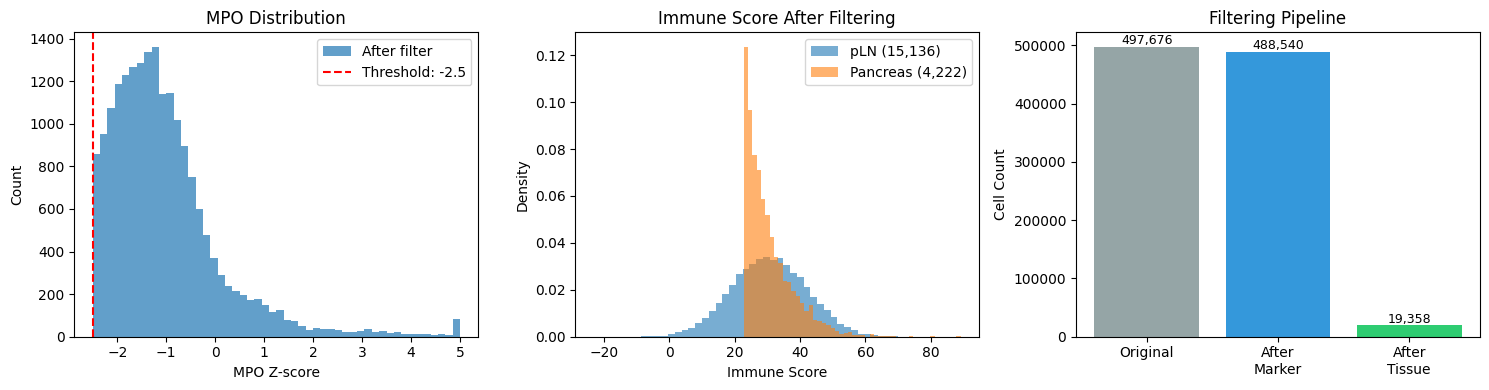

In [31]:
# PRE-FILTER: Remove non-immune Pancreas protein cells AND marker-specific outliers
# The RNA is CD45+ sorted, so we should only match to immune cells in protein data
# Non-immune Pancreas cells (epithelial, stromal) create the "bad mode" in matching

print("=" * 60)
print("PRE-FILTERING: Non-immune cells + marker-specific outliers")
print("=" * 60)

# ============================================================
# FILTER 1: Marker-specific z-score threshold filtering
# Remove cells where specific markers have extreme low values
# ============================================================

# Define markers with z-score thresholds (remove cells below threshold)
MARKER_ZSCORE_THRESHOLDS = {
    'MPO': -2.5,  # MPO has many values at -3.0, filter those out
    # Add more markers here if needed, e.g.:
    # 'CD68': -2.8,
}

print("\n--- Filter 1: Marker-specific z-score thresholds ---")
marker_names = list(protein_shared_adata.var_names)
marker_filter_mask = np.ones(protein_shared.shape[0], dtype=bool)

for marker, threshold in MARKER_ZSCORE_THRESHOLDS.items():
    if marker in marker_names:
        marker_idx = marker_names.index(marker)
        marker_vals = protein_shared[:, marker_idx]
        
        # Count cells below threshold
        below_thresh = marker_vals < threshold
        n_below = below_thresh.sum()
        
        print(f"  {marker}: {n_below:,} cells below z={threshold} ({n_below/len(marker_vals)*100:.1f}%)")
        
        # Update mask
        marker_filter_mask &= ~below_thresh
    else:
        print(f"  {marker}: not found in protein_shared")

n_marker_filtered = (~marker_filter_mask).sum()
print(f"\n  Total removed by marker filter: {n_marker_filtered:,}")

# Apply marker filter first
protein_shared = protein_shared[marker_filter_mask]
protein_active = protein_active[marker_filter_mask]
protein_adata = protein_adata[marker_filter_mask].copy()

# ============================================================
# FILTER 2: Non-immune Pancreas cell filtering  
# ============================================================

print("\n--- Filter 2: Non-immune Pancreas cells ---")

# Get tissue labels (from filtered data)
protein_tissue = protein_adata.obs['Tissue'].values

# Define immune markers to use for filtering
immune_markers = ['CD3E', 'MS4A1', 'CD68', 'PTPRC']  # T cell, B cell, macrophage, CD45
available_immune = [m for m in immune_markers if m in protein_shared_adata.var_names]
print(f"  Immune markers available: {available_immune}")

if len(available_immune) == 0:
    print("  WARNING: No standard immune markers found, using total expression")
    immune_score = protein_shared.sum(axis=1)
else:
    # Calculate immune score as sum of immune marker expression
    marker_idx = [marker_names.index(m) for m in available_immune]
    immune_score = protein_shared[:, marker_idx].sum(axis=1)

# Only filter Pancreas cells - keep all pLN cells
is_pancreas = protein_tissue == 'Pancreas'
is_pln = protein_tissue == 'pLN'

# Threshold: keep Pancreas cells with immune score > threshold
pln_immune_median = np.median(immune_score[is_pln])
pln_immune_25pct = np.percentile(immune_score[is_pln], 25)

threshold = pln_immune_25pct
pancreas_immune_mask = immune_score[is_pancreas] > threshold

print(f"  pLN immune score: median={pln_immune_median:.2f}, 25th pct={pln_immune_25pct:.2f}")
print(f"  Pancreas immune score: median={np.median(immune_score[is_pancreas]):.2f}")
print(f"  Threshold (pLN 25th pct): {threshold:.2f}")

# Create tissue filter mask
tissue_filter_mask = np.ones(len(protein_tissue), dtype=bool)
pancreas_idx = np.where(is_pancreas)[0]
tissue_filter_mask[pancreas_idx[~pancreas_immune_mask]] = False

n_pancreas_removed = is_pancreas.sum() - pancreas_immune_mask.sum()
print(f"\n  Pancreas cells: {is_pancreas.sum():,} → {pancreas_immune_mask.sum():,} ({n_pancreas_removed:,} removed)")
print(f"  pLN cells: {is_pln.sum():,} (all kept)")

# Apply tissue filter
protein_shared = protein_shared[tissue_filter_mask]
protein_active = protein_active[tissue_filter_mask]
protein_adata = protein_adata[tissue_filter_mask].copy()

# ============================================================
# SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("FILTERING SUMMARY")
print("=" * 60)
print(f"  Original cells:        {marker_filter_mask.shape[0]:,}")
print(f"  After marker filter:   {marker_filter_mask.sum():,} (-{n_marker_filtered:,})")
print(f"  After tissue filter:   {protein_shared.shape[0]:,} (-{n_pancreas_removed:,})")
print(f"  Total removed:         {marker_filter_mask.shape[0] - protein_shared.shape[0]:,}")

print(f"\nFinal arrays:")
print(f"  protein_shared: {protein_shared.shape}")
print(f"  protein_active: {protein_active.shape}")
print(f"  protein_adata: {protein_adata.shape}")

# ============================================================
# VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: MPO distribution before/after filtering
ax = axes[0]
if 'MPO' in marker_names:
    mpo_idx = marker_names.index('MPO')
    # Need original data for comparison
    mpo_original = protein_shared_original[:, mpo_idx] if 'protein_shared_original' in dir() else None
    if mpo_original is not None:
        ax.hist(mpo_original, bins=50, alpha=0.5, label='Before filter', edgecolor='none')
    ax.hist(protein_shared[:, mpo_idx], bins=50, alpha=0.7, label='After filter', edgecolor='none')
    ax.axvline(MARKER_ZSCORE_THRESHOLDS.get('MPO', -2.5), color='red', linestyle='--', 
               label=f"Threshold: {MARKER_ZSCORE_THRESHOLDS.get('MPO', -2.5)}")
    ax.set_xlabel('MPO Z-score')
    ax.set_ylabel('Count')
    ax.set_title('MPO Distribution')
    ax.legend()

# Plot 2: Immune score by tissue
ax = axes[1]
# Recalculate for filtered data
protein_tissue_final = protein_adata.obs['Tissue'].values
is_pln_final = protein_tissue_final == 'pLN'
is_pancreas_final = protein_tissue_final == 'Pancreas'
if len(available_immune) > 0:
    marker_idx = [marker_names.index(m) for m in available_immune]
    immune_score_final = protein_shared[:, marker_idx].sum(axis=1)
else:
    immune_score_final = protein_shared.sum(axis=1)

ax.hist(immune_score_final[is_pln_final], bins=50, alpha=0.6, label=f'pLN ({is_pln_final.sum():,})', density=True)
ax.hist(immune_score_final[is_pancreas_final], bins=50, alpha=0.6, label=f'Pancreas ({is_pancreas_final.sum():,})', density=True)
ax.set_xlabel('Immune Score')
ax.set_ylabel('Density')
ax.set_title('Immune Score After Filtering')
ax.legend()

# Plot 3: Summary bar chart
ax = axes[2]
labels = ['Original', 'After\nMarker', 'After\nTissue']
sizes = [marker_filter_mask.shape[0], marker_filter_mask.sum(), protein_shared.shape[0]]
colors = ['#95a5a6', '#3498db', '#2ecc71']
bars = ax.bar(labels, sizes, color=colors)
ax.set_ylabel('Cell Count')
ax.set_title('Filtering Pipeline')
for bar, v in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, v + 5000, f'{v:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

INVESTIGATING Z-SCORE GAP


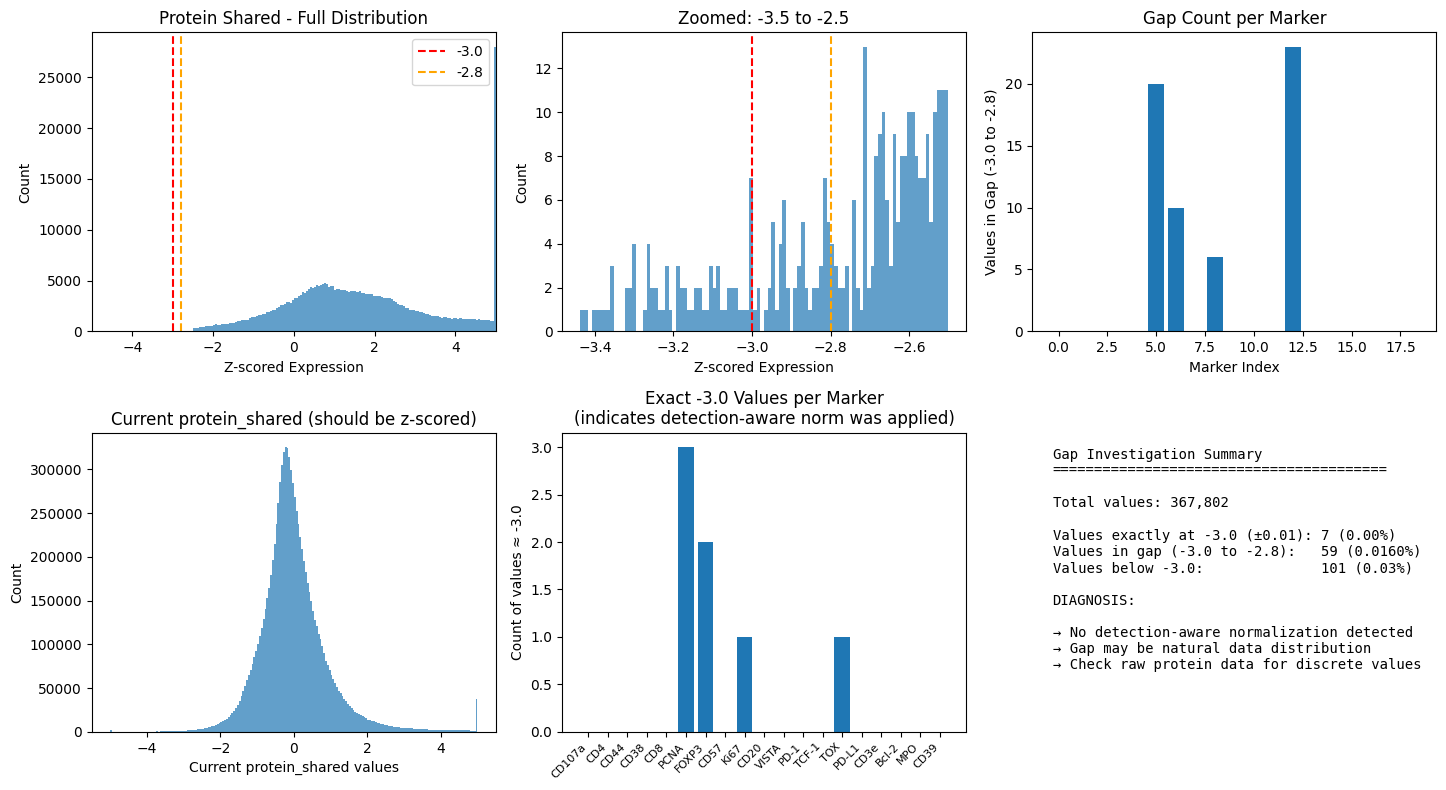


Per-marker statistics for values near -3.0:
------------------------------------------------------------
Marker               ≈-3.0     In Gap        Min       Mean
------------------------------------------------------------
CD107a                   0          0      -3.39      1.358
CD4                      0          0      -1.71      2.766
CD44                     0          0      -3.26      1.181
CD38                     0          0      -1.13      2.423
CD8                      0          0      -1.60      2.633
PCNA                     3         20      -4.23     -0.303
FOXP3                    2         10      -5.00      1.252
CD57                     0          0      -2.71      0.986
Ki67                     1          6      -5.00      0.758
CD20                     0          0      -2.02      1.773
VISTA                    0          0      -2.63      2.309
PD-1                     0          0      -2.71      1.940
TCF-1                    0         23      -3.77     

In [32]:
# DIAGNOSTIC: Investigate the gap between -3.0 and -2.8 in z-scored expression
# This gap shouldn't exist for standard z-scored continuous data

print("=" * 60)
print("INVESTIGATING Z-SCORE GAP")
print("=" * 60)

# Check distribution of protein_shared values
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Overall histogram with fine bins around the gap
ax = axes[0, 0]
hist_vals, bin_edges, _ = ax.hist(protein_shared.flatten(), bins=200, edgecolor='none', alpha=0.7)
ax.axvline(-3.0, color='red', linestyle='--', label='-3.0')
ax.axvline(-2.8, color='orange', linestyle='--', label='-2.8')
ax.set_xlabel('Z-scored Expression')
ax.set_ylabel('Count')
ax.set_title('Protein Shared - Full Distribution')
ax.legend()
ax.set_xlim(-5, 5)

# 2. Zoom into the gap region
ax = axes[0, 1]
gap_region = protein_shared.flatten()[(protein_shared.flatten() > -3.5) & (protein_shared.flatten() < -2.5)]
ax.hist(gap_region, bins=100, edgecolor='none', alpha=0.7)
ax.axvline(-3.0, color='red', linestyle='--')
ax.axvline(-2.8, color='orange', linestyle='--')
ax.set_xlabel('Z-scored Expression')
ax.set_ylabel('Count')
ax.set_title('Zoomed: -3.5 to -2.5')

# 3. Check if gap exists per marker
ax = axes[0, 2]
gap_counts = []
marker_names = list(protein_shared_adata.var_names)
for i in range(protein_shared.shape[1]):
    vals = protein_shared[:, i]
    in_gap = ((vals > -3.0) & (vals < -2.8)).sum()
    gap_counts.append(in_gap)
ax.bar(range(len(marker_names)), gap_counts)
ax.set_xlabel('Marker Index')
ax.set_ylabel('Values in Gap (-3.0 to -2.8)')
ax.set_title('Gap Count per Marker')

# 4. Check the raw protein data before z-scoring
ax = axes[1, 0]
# Reload raw protein shared to check
protein_shared_raw_check = protein_shared_adata.X.copy()
# Reverse z-score to see original distribution pattern
ax.hist(protein_shared_raw_check.flatten(), bins=200, edgecolor='none', alpha=0.7)
ax.set_xlabel('Current protein_shared values')
ax.set_ylabel('Count')
ax.set_title('Current protein_shared (should be z-scored)')

# 5. Check for exact -3.0 values (would indicate detection-aware normalization was applied)
ax = axes[1, 1]
exact_neg3 = np.isclose(protein_shared, -3.0, atol=0.01).sum(axis=0)
ax.bar(range(len(marker_names)), exact_neg3)
ax.set_xticks(range(len(marker_names)))
ax.set_xticklabels(marker_names, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Count of values ≈ -3.0')
ax.set_title('Exact -3.0 Values per Marker\n(indicates detection-aware norm was applied)')

# 6. Summary statistics
ax = axes[1, 2]
ax.axis('off')

n_exact_neg3 = np.isclose(protein_shared, -3.0, atol=0.01).sum()
n_in_gap = ((protein_shared > -3.0) & (protein_shared < -2.8)).sum()
n_below_neg3 = (protein_shared < -3.0).sum()
n_total = protein_shared.size

summary = f"""Gap Investigation Summary
{'='*40}

Total values: {n_total:,}

Values exactly at -3.0 (±0.01): {n_exact_neg3:,} ({n_exact_neg3/n_total*100:.2f}%)
Values in gap (-3.0 to -2.8):   {n_in_gap:,} ({n_in_gap/n_total*100:.4f}%)
Values below -3.0:              {n_below_neg3:,} ({n_below_neg3/n_total*100:.2f}%)

DIAGNOSIS:
"""

if n_exact_neg3 > n_total * 0.01:
    summary += """
→ PROBLEM: Detection-aware normalization was 
  applied to PROTEIN data (should only be RNA)
→ The -3.0 spike is from setting undetected
  values to a fixed value
→ FIX: Re-run normalization cell, or check if
  old cached protein_shared was loaded
"""
else:
    summary += """
→ No detection-aware normalization detected
→ Gap may be natural data distribution
→ Check raw protein data for discrete values
"""

ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print per-marker statistics
print("\nPer-marker statistics for values near -3.0:")
print("-" * 60)
print(f"{'Marker':<15} {'≈-3.0':>10} {'In Gap':>10} {'Min':>10} {'Mean':>10}")
print("-" * 60)
for i, marker in enumerate(marker_names):
    vals = protein_shared[:, i]
    n_neg3 = np.isclose(vals, -3.0, atol=0.01).sum()
    n_gap = ((vals > -3.0) & (vals < -2.8)).sum()
    print(f"{marker:<15} {n_neg3:>10,} {n_gap:>10,} {vals.min():>10.2f} {vals.mean():>10.3f}")

## Step 7: MaxFuse Integration

MaxFuse performs the integration in several stages:
1. Split data into batches for scalability
2. Construct k-NN graphs and cluster cells
3. Find initial pivot matches using shared features
4. Refine pivots using CCA on all features
5. Propagate matching to all cells

In [33]:
# Create Fusor - let MaxFuse cluster automatically
# IMPORTANT: Run the pre-filter cell BEFORE this cell

# Verify we're using filtered data
print("=" * 60)
print("CREATING FUSOR WITH CURRENT ARRAYS")
print("=" * 60)
print(f"  rna_shared:     {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")
print(f"  rna_active:     {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")

# Sanity check - if protein has >400k cells, filter probably didn't run
if protein_shared.shape[0] > 400000:
    print("\n⚠️  WARNING: protein_shared has >400k cells!")
    print("    Did you run the pre-filter cell first?")
    print("    Re-run from the pre-filter cell to apply filtering.")

fusor = Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None,
    method='centroid_shrinkage'
)

print(f"\nFusor created successfully.")

CREATING FUSOR WITH CURRENT ARRAYS
  rna_shared:     (10817, 19)
  protein_shared: (19358, 19)
  rna_active:     (10817, 20937)
  protein_active: (19358, 19)

Fusor created successfully.


In [34]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)

# CRITICAL FIX: For very large protein:RNA ratios, cap the matching ratio
# The algorithm propagates matches via pivot cells, so we don't need every
# protein cell in initial batches. Using sqrt scaling prevents over-sampling
# that leads to excessive filtering and cell loss.
matching_ratio = min(100, max(10, int(np.sqrt(ratio)) + 5))  # sqrt scaling for large ratios

# Metacell size: with only 19 features, metacells of size 2 provide minimal benefit
# Use size=1 (no metacells) for direct cell matching, or increase to 5+ for noise reduction
metacell_sz = 1  # No metacells - direct matching with small feature panel

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio} (sqrt-scaled, capped at 100)")
print(f"  metacell_size: {metacell_sz} (disabled for 19-marker panel)")

RNA cells: 10817
Protein cells: 19358
Ratio (protein/RNA): 1.8

Batching parameters:
  max_outward_size: 8000
  matching_ratio: 10 (sqrt-scaled, capped at 100)
  metacell_size: 1 (disabled for 19-marker panel)


In [35]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 5 batches, average batch size is 2163, and max batch size is 2165.
The second data is split into 1 batches, average batch size is 19358, and max batch size is 19358.
Batch to batch correspondence is:
  ['0<->0', '1<->0', '2<->0', '3<->0', '4<->0'].


### Tissue-Aware Matching Priors

Since the data contains cells from two tissues (pLN and Pancreas), we configure priors to penalize cross-tissue matches. This ensures that pLN RNA cells preferentially match to pLN protein cells, and Pancreas RNA cells to Pancreas protein cells.

The weight matrix uses:
- **0.1** for same-tissue matches (favorable)
- **10.0** for cross-tissue matches (penalized 100x)

In [36]:
# Configure tissue-aware matching priors
# Penalize cross-tissue matches (pLN ↔ Pancreas) while allowing same-tissue matches

# Verify arrays match protein_adata
print("=" * 60)
print("CONFIGURING TISSUE PRIORS")
print("=" * 60)
print(f"  protein_adata: {protein_adata.shape[0]:,} cells")
print(f"  protein_shared: {protein_shared.shape[0]:,} cells")

if protein_adata.shape[0] != protein_shared.shape[0]:
    print("\n⚠️  WARNING: protein_adata and protein_shared have different sizes!")
    print("    Re-run from the pre-filter cell to sync arrays.")

# Get tissue labels from loaded data
rna_tissue = rna_adata.obs['Tissue'].values
protein_tissue = protein_adata.obs['Tissue'].values

print(f"\nTissue distribution:")
print(f"  RNA - pLN: {(rna_tissue == 'pLN').sum():,}, Pancreas: {(rna_tissue == 'Pancreas').sum():,}")
print(f"  Protein - pLN: {(protein_tissue == 'pLN').sum():,}, Pancreas: {(protein_tissue == 'Pancreas').sum():,}")

# Define tissue compatibility weights
# Low weight (0.1) = compatible, High weight (10.0) = incompatible
tissue_weights = {
    'pLN': {'pLN': 0.1, 'Pancreas': 10.0},
    'Pancreas': {'pLN': 10.0, 'Pancreas': 0.1}
}

# Set tissue priors - using tissue labels as both "cell types" and "regions"
# INCREASED weight from 0.3 to 0.7 to more strongly penalize cross-tissue matches
fusor.set_region_priors(
    rna_labels=rna_tissue,
    spatial_regions=protein_tissue,
    celltype_to_region_weights=tissue_weights,
    wt_on_prior=0.7,  # Increased from 0.3 - stronger tissue enforcement
    verbose=True
)

print("\nTissue priors configured: cross-tissue matches penalized 100x")
print("  Prior weight: 0.7 (increased from 0.3)")
print("  Priors applied during refine_pivots (not initial pivots)")

CONFIGURING TISSUE PRIORS
  protein_adata: 19,358 cells
  protein_shared: 19,358 cells

Tissue distribution:
  RNA - pLN: 10,141, Pancreas: 676
  Protein - pLN: 15,136, Pancreas: 4,222
Configured region priors:
  RNA cell types: 2
  Spatial regions: 2
  Prior weight: 0.7

Tissue priors configured: cross-tissue matches penalized 100x
  Prior weight: 0.7 (increased from 0.3)
  Priors applied during refine_pivots (not initial pivots)


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

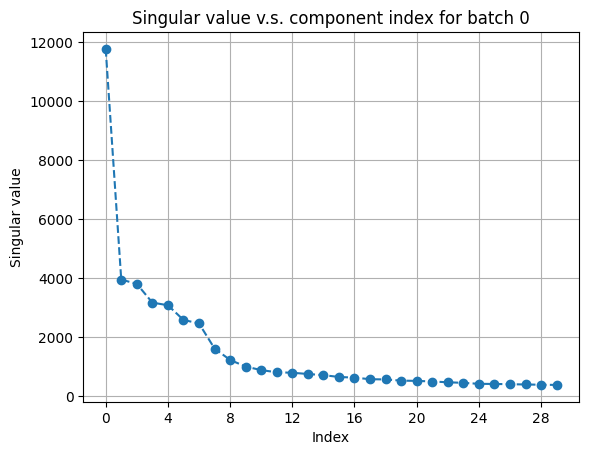

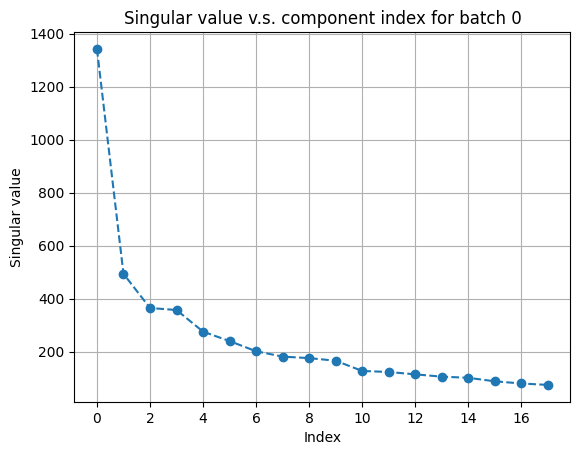

In [37]:
# Plot singular values to determine SVD components
# Explicitly use batch=0 to investigate singular value behavior
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plt.sca(axes[0])
fusor.plot_singular_values(target='active_arr1', batch=0, n_components=30)
# axes[0].set_title('RNA Active - Singular Values (Batch 0)')

# plt.sca(axes[1])
# For protein, cap n_components at n_features - 1
n_prot_comp = min(18, protein_active.shape[1] - 1)
fusor.plot_singular_values(target='active_arr2', batch=0, n_components=n_prot_comp)
# axes[1].set_title(f'Protein Active - Singular Values (Batch 0, {protein_active.shape[1]} features)')

# plt.tight_layout()
# plt.show()

In [38]:
# Set SVD components based on data dimensions
# NOTE: Parameters adjusted for 19-marker reduced dataset
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

print(f"Dataset dimensions:")
print(f"  Protein features: {n_prot_features}")
print(f"  RNA features: {n_rna_features}")
print(f"  Shared features: {n_shared}")

# Graph construction: SVD components must be < n_features
# For small protein panels, use conservative values
svd_comp1_graph = min(50, n_rna_features - 1)  # RNA: plenty of features
svd_comp2_graph = min(15, n_prot_features - 1)  # Protein: cap at 15 for 19 markers

print(f"\nGraph construction SVD components:")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph} (capped for {n_prot_features}-marker panel)")

Dataset dimensions:
  Protein features: 19
  RNA features: 20937
  Shared features: 19

Graph construction SVD components:
  RNA: 50
  Protein: 15 (capped for 19-marker panel)


In [39]:
# Construct graphs with automatic clustering
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution2=2.0,
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


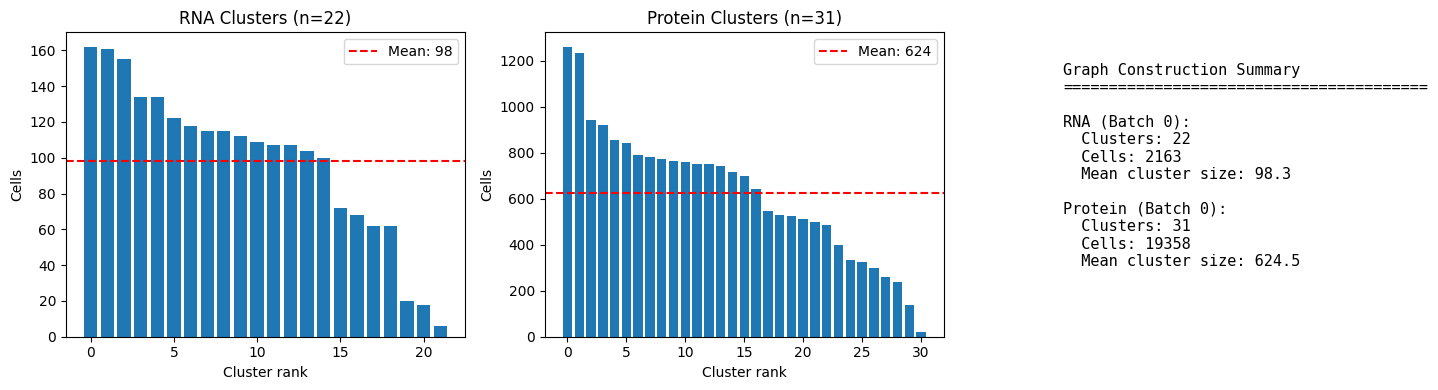

In [40]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get cluster labels from first batch
labels1_b0 = fusor._labels1[0]
labels2_b0 = fusor._labels2[0]

# RNA cluster sizes
ax = axes[0]
unique, counts = np.unique(labels1_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'RNA Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Protein cluster sizes
ax = axes[1]
unique, counts = np.unique(labels2_b0, return_counts=True)
ax.bar(range(len(counts)), sorted(counts, reverse=True))
ax.set_xlabel('Cluster rank')
ax.set_ylabel('Cells')
ax.set_title(f'Protein Clusters (n={len(unique)})')
ax.axhline(y=np.mean(counts), color='r', linestyle='--', label=f'Mean: {np.mean(counts):.0f}')
ax.legend()

# Summary stats
ax = axes[2]
ax.axis('off')
stats_text = f'''Graph Construction Summary
{"="*40}

RNA (Batch 0):
  Clusters: {len(np.unique(labels1_b0))}
  Cells: {len(labels1_b0)}
  Mean cluster size: {np.mean(np.bincount(labels1_b0)):.1f}

Protein (Batch 0):
  Clusters: {len(np.unique(labels2_b0))}
  Cells: {len(labels2_b0)}
  Mean cluster size: {np.mean(np.bincount(labels2_b0)):.1f}
'''
ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [41]:
# Find initial pivots with smoothing for weak linkage
# For 19-marker panel, SVD components must be < n_shared
svd_shared1 = min(15, n_shared - 1)  # Conservative for small panel
svd_shared2 = min(15, n_shared - 1)  # Same for protein
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")
print(f"  (n_shared = {n_shared})")

fusor.find_initial_pivots(
    wt1=0.3,  # Smoothing weight
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    use_region_priors=False,  # Skip priors for initial pivots (faster, priors applied in refinement)
    verbose=True
)

Using 15/15 SVD components for shared features
  (n_shared = 19)
Now at batch 0<->0...
Now at batch 1<->0...
Now at batch 2<->0...
Now at batch 3<->0...
Now at batch 4<->0...
Done!


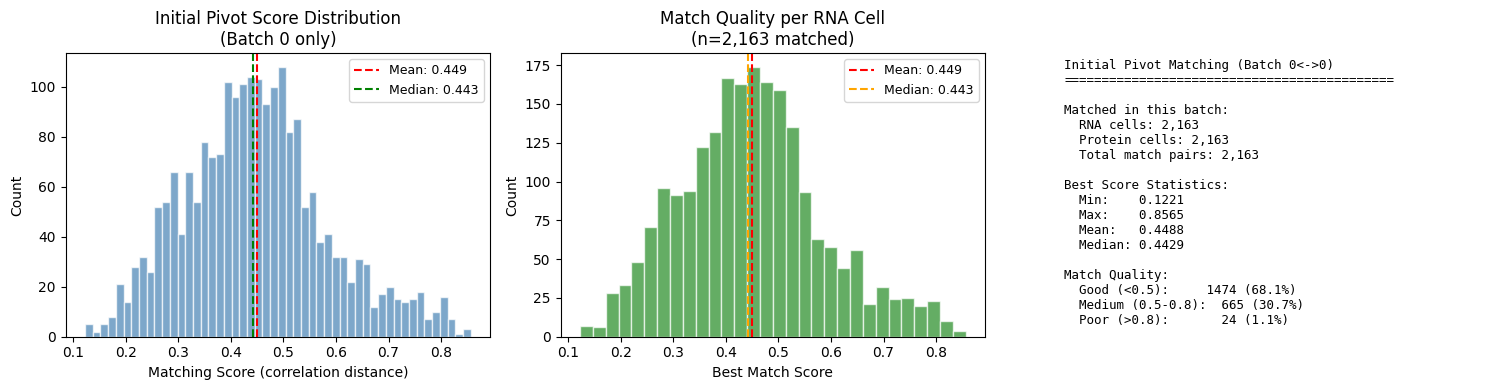


Total batches: 5
Total matches across all batches: 10,817


In [42]:
# Visualize initial pivot matching
# NOTE: Initial matching operates on METACELLS, not individual cells
# With metacell_size=2, ~1284 cells become ~642 metacells

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get initial matching from first batch (batch 0<->0)
init_match = fusor._init_matching[0]
init_rows, init_cols, init_scores = init_match

# Determine if metacells were used
using_metacells = fusor.metacell_size > 1
n_metacells = len(np.unique(init_rows)) if using_metacells else None

# Plot 1: Score distribution
ax = axes[0]
ax.hist(init_scores, bins=50, edgecolor='white', alpha=0.7, color='steelblue')
ax.axvline(np.mean(init_scores), color='r', linestyle='--', 
           label=f'Mean: {np.mean(init_scores):.3f}')
ax.axvline(np.median(init_scores), color='g', linestyle='--',
           label=f'Median: {np.median(init_scores):.3f}')
ax.set_xlabel('Matching Score (correlation distance)')
ax.set_ylabel('Count')
ax.set_title('Initial Pivot Score Distribution\n(Batch 0 only)')
ax.legend(fontsize=9)

# Plot 2: Best score per RNA metacell/cell
ax = axes[1]
unique_rna = np.unique(init_rows)
best_scores = []
for rna_idx in unique_rna:
    mask = init_rows == rna_idx
    best_scores.append(np.min(init_scores[mask]))
best_scores = np.array(best_scores)

ax.hist(best_scores, bins=30, edgecolor='white', alpha=0.7, color='forestgreen')
ax.axvline(np.mean(best_scores), color='r', linestyle='--',
           label=f'Mean: {np.mean(best_scores):.3f}')
ax.axvline(np.median(best_scores), color='orange', linestyle='--',
           label=f'Median: {np.median(best_scores):.3f}')
ax.set_xlabel('Best Match Score')
ax.set_ylabel('Count')
unit = 'Metacell' if using_metacells else 'Cell'
ax.set_title(f'Match Quality per RNA {unit}\n(n={len(unique_rna):,} matched)')
ax.legend(fontsize=9)

# Plot 3: Summary statistics
ax = axes[2]
ax.axis('off')

n_matched = len(unique_rna)
n_rna_total = rna_shared.shape[0]
n_prot_matched = len(np.unique(init_cols))

# Categorize match quality
good = (best_scores < 0.5).sum()
medium = ((best_scores >= 0.5) & (best_scores < 0.8)).sum()
poor = (best_scores >= 0.8).sum()

if using_metacells:
    metacell_note = f"""
NOTE: Using metacell_size={fusor.metacell_size}
  {n_rna_total:,} RNA cells → {n_matched:,} metacells
  All cells are represented via metacells!
"""
else:
    metacell_note = ""

stats = f"""Initial Pivot Matching (Batch 0<->0)
{"="*44}
{metacell_note}
Matched in this batch:
  RNA {"metacells" if using_metacells else "cells"}: {n_matched:,}
  Protein cells: {n_prot_matched:,}
  Total match pairs: {len(init_scores):,}

Best Score Statistics:
  Min:    {np.min(best_scores):.4f}
  Max:    {np.max(best_scores):.4f}
  Mean:   {np.mean(best_scores):.4f}
  Median: {np.median(best_scores):.4f}

Match Quality:
  Good (<0.5):     {good:>4} ({good/n_matched*100:.1f}%)
  Medium (0.5-0.8): {medium:>4} ({medium/n_matched*100:.1f}%)
  Poor (>0.8):     {poor:>4} ({poor/n_matched*100:.1f}%)
"""
ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print info about all batches
print(f"\nTotal batches: {len(fusor._init_matching)}")
total_matches = sum(len(m[0]) for m in fusor._init_matching)
print(f"Total matches across all batches: {total_matches:,}")
if using_metacells:
    print(f"\nMetacell aggregation: {n_rna_total} cells → ~{n_rna_total // fusor.metacell_size} metacells")
    print("All RNA cells are represented through their metacells.")


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 1<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

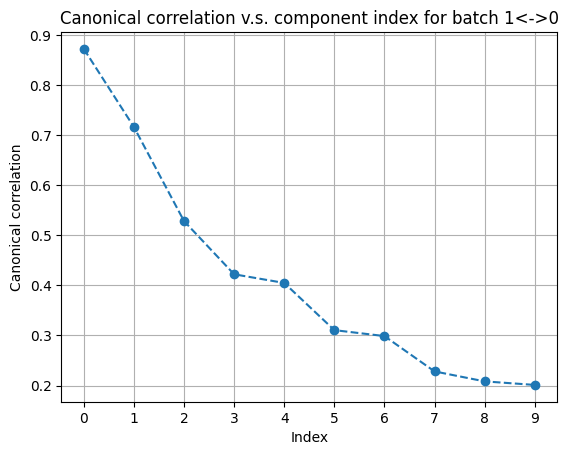

In [43]:
# Check canonical correlations
# Use same SVD limits as refine_pivots
cca_comp_check = min(10, n_shared - 1)  # Match refine_pivots CCA components
fusor.plot_canonical_correlations(
    svd_components1=min(50, n_rna_features - 1),   # Match refine_pivots
    svd_components2=min(15, n_prot_features - 1),  # Match refine_pivots (capped for 19 markers)
    cca_components=cca_comp_check
)

In [44]:
# Refine pivots using CCA
# CRITICAL: CCA component selection for 19-marker dataset
# With protein_active == protein_shared (same 19 markers), we can't use the
# "active minus shared" logic. Instead, use conservative CCA based on shared features.

# For small panels: CCA components should be well below n_shared to avoid overfitting
cca_components = min(n_shared - 1, 10)  # Cap at 10 for small panels
cca_components = max(5, cca_components)  # At least 5 components

print(f"CCA components: {cca_components}")
print(f"  (n_shared={n_shared}, using min(n_shared-1, 10) rule for small panels)")

# SVD before CCA: must be < n_features for both modalities
svd_cca_rna = min(50, n_rna_features - 1)      # RNA: plenty of headroom
svd_cca_prot = min(15, n_prot_features - 1)    # Protein: cap at 15 for 19 markers

print(f"SVD before CCA: RNA={svd_cca_rna}, Protein={svd_cca_prot}")

fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=svd_cca_rna,
    svd_components2=svd_cca_prot,
    cca_components=cca_components,
    n_iters=1,
    filter_prop=0.0,
    verbose=True
)

CCA components: 10
  (n_shared=19, using min(n_shared-1, 10) rule for small panels)
SVD before CCA: RNA=50, Protein=15
Now at batch 0<->0...
  Using region priors with weight 0.7
Now at batch 1<->0...
  Using region priors with weight 0.7
Now at batch 2<->0...
  Using region priors with weight 0.7
Now at batch 3<->0...
  Using region priors with weight 0.7
Now at batch 4<->0...
  Using region priors with weight 0.7
Done!


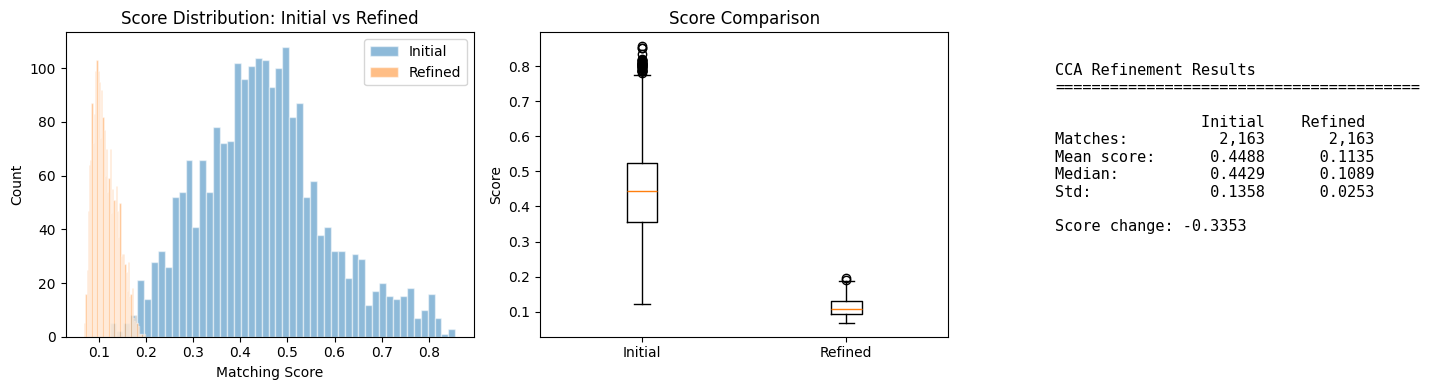

In [45]:
# Compare initial vs refined matching
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get refined matching
refined_match = fusor._refined_matching[0]
ref_rows, ref_cols, ref_scores = refined_match

# Score comparison
ax = axes[0]
ax.hist(init_scores, bins=50, alpha=0.5, label='Initial', edgecolor='white')
ax.hist(ref_scores, bins=50, alpha=0.5, label='Refined', edgecolor='white')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution: Initial vs Refined')
ax.legend()

# Score improvement
ax = axes[1]
ax.boxplot([init_scores, ref_scores], labels=['Initial', 'Refined'])
ax.set_ylabel('Score')
ax.set_title('Score Comparison')

# Summary
ax = axes[2]
ax.axis('off')
stats = f'''CCA Refinement Results
{"="*40}

                Initial    Refined
Matches:     {len(init_scores):>10,}  {len(ref_scores):>10,}
Mean score:  {np.mean(init_scores):>10.4f}  {np.mean(ref_scores):>10.4f}
Median:      {np.median(init_scores):>10.4f}  {np.median(ref_scores):>10.4f}
Std:         {np.std(init_scores):>10.4f}  {np.std(ref_scores):>10.4f}

Score change: {np.mean(ref_scores) - np.mean(init_scores):+.4f}
'''
ax.text(0.1, 0.9, stats, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

GMM Analysis of Pivot Matching Scores
Mode 1 (good): mean=0.097, std=0.013, weight=60.3%
Mode 2 (bad):  mean=0.138, std=0.019, weight=39.7%

Recommended filter_prop: 0.40 (fraction in bad mode)
Threshold between modes: 0.118


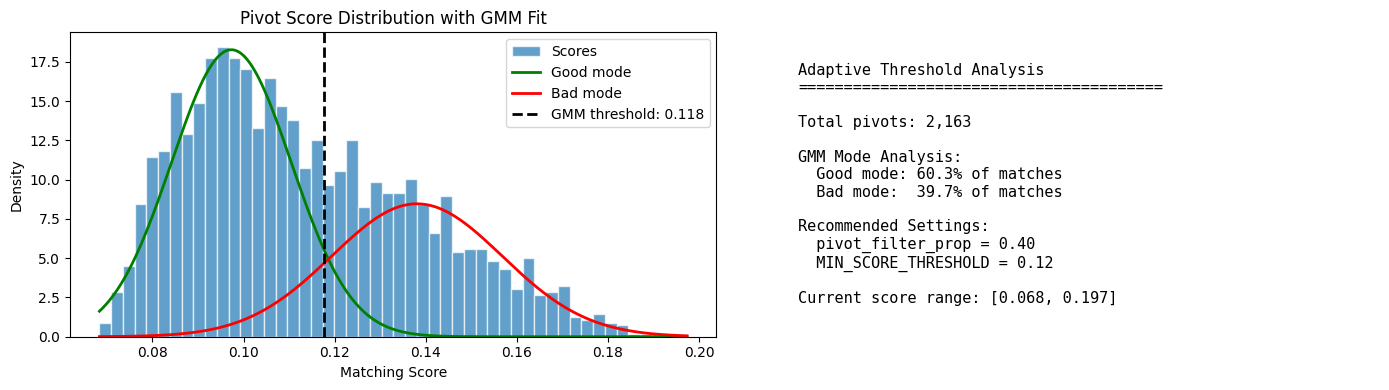

In [46]:
# Analyze pivot score distribution with Gaussian Mixture Model
# This helps identify bimodal distribution and set adaptive thresholds
from sklearn.mixture import GaussianMixture

# Get pivot matching scores from refined matching
pivot_match = fusor._refined_matching[0]  # First batch
pivot_scores = np.array(pivot_match[2])

# Fit Gaussian Mixture to detect two modes
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pivot_scores.reshape(-1, 1))
means = gmm.means_.flatten()
weights = gmm.weights_
stds = np.sqrt(gmm.covariances_.flatten())

# Identify good vs bad mode (lower score = better match for distance-based)
good_mode_idx = np.argmin(means)
bad_mode_idx = np.argmax(means)

print("GMM Analysis of Pivot Matching Scores")
print("=" * 50)
print(f"Mode 1 (good): mean={means[good_mode_idx]:.3f}, std={stds[good_mode_idx]:.3f}, weight={weights[good_mode_idx]:.1%}")
print(f"Mode 2 (bad):  mean={means[bad_mode_idx]:.3f}, std={stds[bad_mode_idx]:.3f}, weight={weights[bad_mode_idx]:.1%}")

# Threshold at midpoint between modes
gmm_threshold = (means[0] + means[1]) / 2
bad_mode_fraction = weights[bad_mode_idx]

print(f"\nRecommended filter_prop: {bad_mode_fraction:.2f} (fraction in bad mode)")
print(f"Threshold between modes: {gmm_threshold:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram with GMM fit
ax = axes[0]
x = np.linspace(pivot_scores.min(), pivot_scores.max(), 200)
ax.hist(pivot_scores, bins=50, density=True, alpha=0.7, edgecolor='white', label='Scores')

# Plot GMM components
from scipy.stats import norm
for i in range(2):
    color = 'green' if i == good_mode_idx else 'red'
    label = 'Good mode' if i == good_mode_idx else 'Bad mode'
    ax.plot(x, weights[i] * norm.pdf(x, means[i], stds[i]), 
            color=color, linewidth=2, label=label)

ax.axvline(gmm_threshold, color='black', linestyle='--', linewidth=2, label=f'GMM threshold: {gmm_threshold:.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Density')
ax.set_title('Pivot Score Distribution with GMM Fit')
ax.legend()

# Score ranges
ax = axes[1]
ax.axis('off')
summary = f'''Adaptive Threshold Analysis
{"="*40}

Total pivots: {len(pivot_scores):,}

GMM Mode Analysis:
  Good mode: {weights[good_mode_idx]:.1%} of matches
  Bad mode:  {weights[bad_mode_idx]:.1%} of matches

Recommended Settings:
  pivot_filter_prop = {bad_mode_fraction:.2f}
  MIN_SCORE_THRESHOLD = {gmm_threshold:.2f}

Current score range: [{pivot_scores.min():.3f}, {pivot_scores.max():.3f}]
'''
ax.text(0.1, 0.9, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

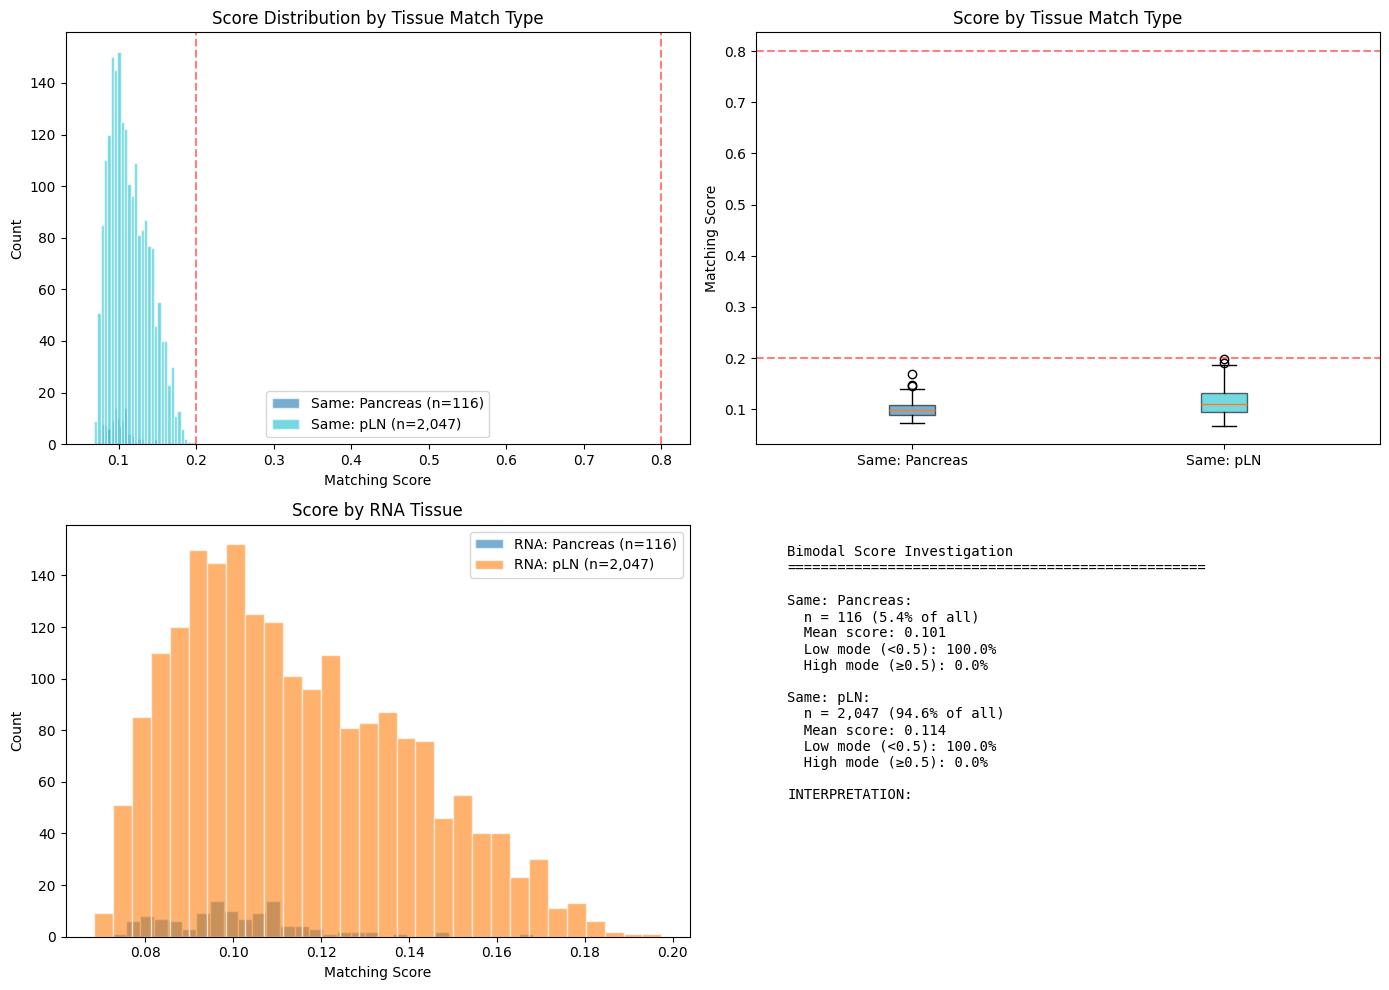


Cross-tabulation of tissue matches:
col_0     Pancreas   pLN   All
row_0                         
Pancreas       116     0   116
pLN              0  2047  2047
All            116  2047  2163


In [47]:
# DIAGNOSTIC: Investigate bimodal score distribution
# Hypothesis: The two modes may correspond to tissue types (pLN vs Pancreas)

# Get matching data
pivot_match = fusor._refined_matching[0]
ref_rows, ref_cols, ref_scores = pivot_match
ref_scores = np.array(ref_scores)

# Get batch indices - _batch1_to_batch2 is a list of (b1, b2) tuples
b1, b2 = fusor._batch1_to_batch2[0]
rna_indices = np.array(fusor._batch_to_indices1[b1])
prot_indices = np.array(fusor._batch_to_indices2[b2])

# Get tissue labels for matched cells
rna_tissues = rna_adata.obs['Tissue'].values[rna_indices[ref_rows]]
prot_tissues = protein_adata.obs['Tissue'].values[prot_indices[ref_cols]]

# Categorize matches by tissue combination
match_types = []
for rt, pt in zip(rna_tissues, prot_tissues):
    if rt == pt:
        match_types.append(f'Same: {rt}')
    else:
        match_types.append(f'Cross: {rt}↔{pt}')
match_types = np.array(match_types)

# Analyze scores by match type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score distribution by tissue match type
ax = axes[0, 0]
unique_types = np.unique(match_types)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
for i, mt in enumerate(unique_types):
    mask = match_types == mt
    ax.hist(ref_scores[mask], bins=30, alpha=0.6, label=f'{mt} (n={mask.sum():,})', 
            edgecolor='white', color=colors[i])
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Distribution by Tissue Match Type')
ax.legend()
ax.axvline(0.2, color='red', linestyle='--', alpha=0.5)
ax.axvline(0.8, color='red', linestyle='--', alpha=0.5)

# 2. Boxplot by tissue type
ax = axes[0, 1]
data_for_box = [ref_scores[match_types == mt] for mt in unique_types]
bp = ax.boxplot(data_for_box, labels=[mt.replace('↔', '\n↔') for mt in unique_types], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel('Matching Score')
ax.set_title('Score by Tissue Match Type')
ax.axhline(0.2, color='red', linestyle='--', alpha=0.5, label='Mode 1 (~0.2)')
ax.axhline(0.8, color='red', linestyle='--', alpha=0.5, label='Mode 2 (~0.8)')

# 3. Score vs RNA tissue
ax = axes[1, 0]
rna_tissue_unique = np.unique(rna_tissues)
for i, tissue in enumerate(rna_tissue_unique):
    mask = rna_tissues == tissue
    ax.hist(ref_scores[mask], bins=30, alpha=0.6, label=f'RNA: {tissue} (n={mask.sum():,})', edgecolor='white')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score by RNA Tissue')
ax.legend()

# 4. Summary statistics
ax = axes[1, 1]
ax.axis('off')
summary_lines = ['Bimodal Score Investigation', '=' * 50, '']

for mt in unique_types:
    mask = match_types == mt
    scores_mt = ref_scores[mask]
    # Categorize into low (<0.5) and high (>=0.5) modes
    low_frac = (scores_mt < 0.5).mean()
    high_frac = (scores_mt >= 0.5).mean()
    summary_lines.append(f'{mt}:')
    summary_lines.append(f'  n = {mask.sum():,} ({mask.mean()*100:.1f}% of all)')
    summary_lines.append(f'  Mean score: {scores_mt.mean():.3f}')
    summary_lines.append(f'  Low mode (<0.5): {low_frac*100:.1f}%')
    summary_lines.append(f'  High mode (≥0.5): {high_frac*100:.1f}%')
    summary_lines.append('')

# Overall interpretation
same_tissue_mask = np.array(['Same' in mt for mt in match_types])
cross_tissue_mask = ~same_tissue_mask
summary_lines.append('INTERPRETATION:')
if same_tissue_mask.sum() > 0 and cross_tissue_mask.sum() > 0:
    same_mean = ref_scores[same_tissue_mask].mean()
    cross_mean = ref_scores[cross_tissue_mask].mean()
    summary_lines.append(f'  Same-tissue mean: {same_mean:.3f}')
    summary_lines.append(f'  Cross-tissue mean: {cross_mean:.3f}')
    if abs(same_mean - cross_mean) > 0.2:
        summary_lines.append('  → Bimodality likely due to tissue mismatch!')
    else:
        summary_lines.append('  → Tissue type does NOT explain bimodality')

ax.text(0.05, 0.95, '\n'.join(summary_lines), transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print cross-tabulation
print("\nCross-tabulation of tissue matches:")
print(pd.crosstab(rna_tissues, prot_tissues, margins=True))

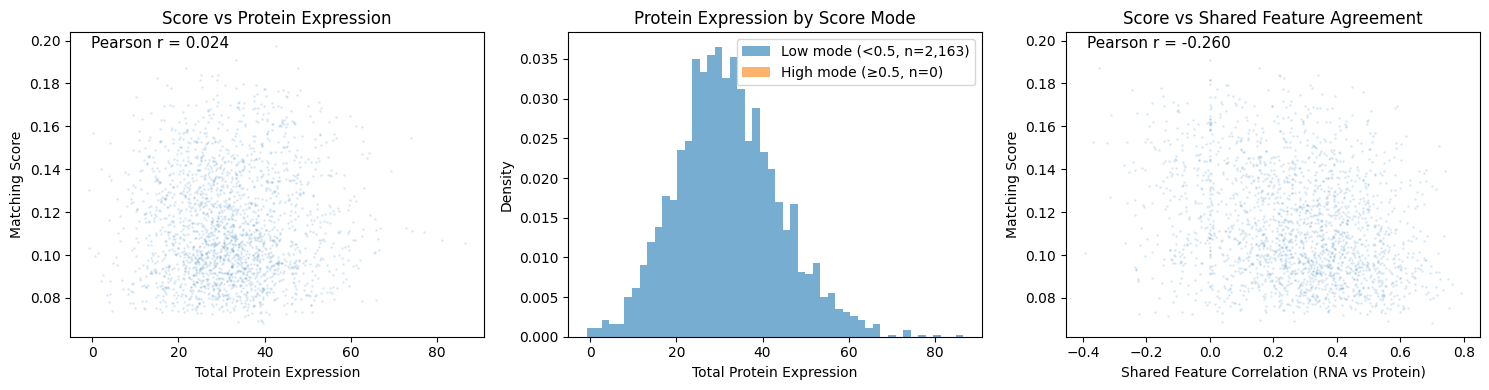


Summary Statistics:
Low mode (<0.5):  mean protein expr = 32.00, mean shared corr = 0.269
High mode (≥0.5): mean protein expr = nan, mean shared corr = nan


In [48]:
# DIAGNOSTIC: Check if protein expression levels correlate with score modes
# Hypothesis: Low-expressing cells may have worse matching scores

# Get protein expression for matched cells
prot_matched_indices = prot_indices[ref_cols]
prot_expr = protein_active[prot_matched_indices, :]

# Calculate total protein expression per cell
prot_total_expr = np.sum(prot_expr, axis=1)

# Categorize scores into modes
low_mode = ref_scores < 0.5
high_mode = ref_scores >= 0.5

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Score vs total protein expression
ax = axes[0]
ax.scatter(prot_total_expr, ref_scores, alpha=0.1, s=1)
ax.set_xlabel('Total Protein Expression')
ax.set_ylabel('Matching Score')
ax.set_title('Score vs Protein Expression')
# Add correlation
corr = np.corrcoef(prot_total_expr, ref_scores)[0, 1]
ax.text(0.05, 0.95, f'Pearson r = {corr:.3f}', transform=ax.transAxes, fontsize=11)

# 2. Protein expression distribution by score mode
ax = axes[1]
ax.hist(prot_total_expr[low_mode], bins=50, alpha=0.6, label=f'Low mode (<0.5, n={low_mode.sum():,})', density=True)
ax.hist(prot_total_expr[high_mode], bins=50, alpha=0.6, label=f'High mode (≥0.5, n={high_mode.sum():,})', density=True)
ax.set_xlabel('Total Protein Expression')
ax.set_ylabel('Density')
ax.set_title('Protein Expression by Score Mode')
ax.legend()

# 3. Check shared feature correlations
# Get shared features for matched pairs
rna_matched_indices = rna_indices[ref_rows]
rna_shared_matched = rna_shared[rna_matched_indices, :]
prot_shared_matched = protein_shared[prot_matched_indices, :]

# Calculate per-pair correlation across shared features
pair_correlations = []
for i in range(len(ref_rows)):
    r = np.corrcoef(rna_shared_matched[i, :], prot_shared_matched[i, :])[0, 1]
    pair_correlations.append(r if not np.isnan(r) else 0)
pair_correlations = np.array(pair_correlations)

ax = axes[2]
ax.scatter(pair_correlations, ref_scores, alpha=0.1, s=1)
ax.set_xlabel('Shared Feature Correlation (RNA vs Protein)')
ax.set_ylabel('Matching Score')
ax.set_title('Score vs Shared Feature Agreement')
corr2 = np.corrcoef(pair_correlations, ref_scores)[0, 1]
ax.text(0.05, 0.95, f'Pearson r = {corr2:.3f}', transform=ax.transAxes, fontsize=11)

plt.tight_layout()
plt.show()

# Summary
print("\nSummary Statistics:")
print(f"Low mode (<0.5):  mean protein expr = {prot_total_expr[low_mode].mean():.2f}, "
      f"mean shared corr = {pair_correlations[low_mode].mean():.3f}")
print(f"High mode (≥0.5): mean protein expr = {prot_total_expr[high_mode].mean():.2f}, "
      f"mean shared corr = {pair_correlations[high_mode].mean():.3f}")

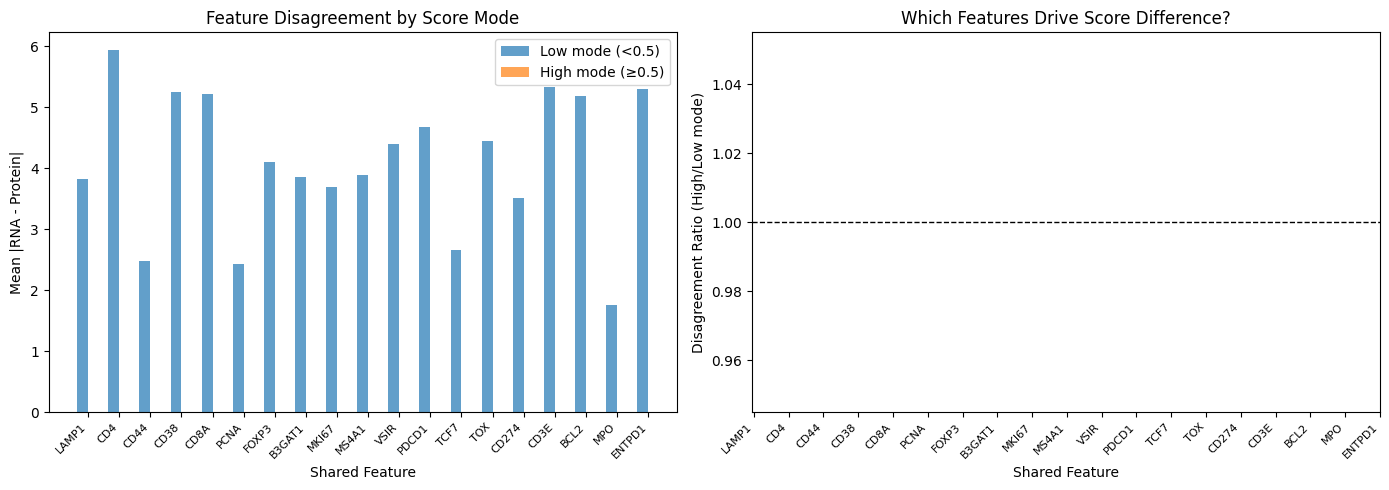


Features with largest mode difference:
--------------------------------------------------
  CD4            : diff=+nan (worse in low mode)
  CD44           : diff=+nan (worse in low mode)
  CD38           : diff=+nan (worse in low mode)
  CD8A           : diff=+nan (worse in low mode)
  PCNA           : diff=+nan (worse in low mode)
  FOXP3          : diff=+nan (worse in low mode)
  B3GAT1         : diff=+nan (worse in low mode)
  MKI67          : diff=+nan (worse in low mode)
  LAMP1          : diff=+nan (worse in low mode)
  VSIR           : diff=+nan (worse in low mode)


In [49]:
# DIAGNOSTIC: Check if specific markers drive the bimodality
# Look at which shared features differ most between low and high score modes

# Get shared feature names
shared_feature_names = list(rna_shared_adata.var_names)

# Per-feature agreement for each matched pair (reusing variables from cell 56)
feature_diffs = np.abs(rna_shared_matched - prot_shared_matched)

# Compare feature differences between low and high mode matches
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Mean feature difference by score mode
ax = axes[0]
low_mode_diffs = feature_diffs[low_mode, :].mean(axis=0)
high_mode_diffs = feature_diffs[high_mode, :].mean(axis=0)

x = np.arange(len(shared_feature_names))
width = 0.35
ax.bar(x - width/2, low_mode_diffs, width, label='Low mode (<0.5)', alpha=0.7)
ax.bar(x + width/2, high_mode_diffs, width, label='High mode (≥0.5)', alpha=0.7)
ax.set_xlabel('Shared Feature')
ax.set_ylabel('Mean |RNA - Protein|')
ax.set_title('Feature Disagreement by Score Mode')
ax.set_xticks(x)
ax.set_xticklabels(shared_feature_names, rotation=45, ha='right', fontsize=8)
ax.legend()

# 2. Ratio of disagreement (high mode / low mode)
ax = axes[1]
ratio = high_mode_diffs / (low_mode_diffs + 1e-6)
colors = ['red' if r > 1.5 else 'green' if r < 0.67 else 'gray' for r in ratio]
ax.bar(x, ratio, color=colors, alpha=0.7)
ax.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Shared Feature')
ax.set_ylabel('Disagreement Ratio (High/Low mode)')
ax.set_title('Which Features Drive Score Difference?')
ax.set_xticks(x)
ax.set_xticklabels(shared_feature_names, rotation=45, ha='right', fontsize=8)

# Highlight problematic features
problematic = [(shared_feature_names[i], ratio[i]) for i in range(len(ratio)) if ratio[i] > 1.5]
if problematic:
    ax.text(0.02, 0.98, 'Red bars: worse in high-score mode', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', color='red')

plt.tight_layout()
plt.show()

# Print summary of most divergent features
print("\nFeatures with largest mode difference:")
print("-" * 50)
diff_of_diffs = high_mode_diffs - low_mode_diffs
sorted_idx = np.argsort(np.abs(diff_of_diffs))[::-1]
for i in sorted_idx[:10]:
    direction = "worse in high mode" if diff_of_diffs[i] > 0 else "worse in low mode"
    print(f"  {shared_feature_names[i]:15s}: diff={diff_of_diffs[i]:+.3f} ({direction})")

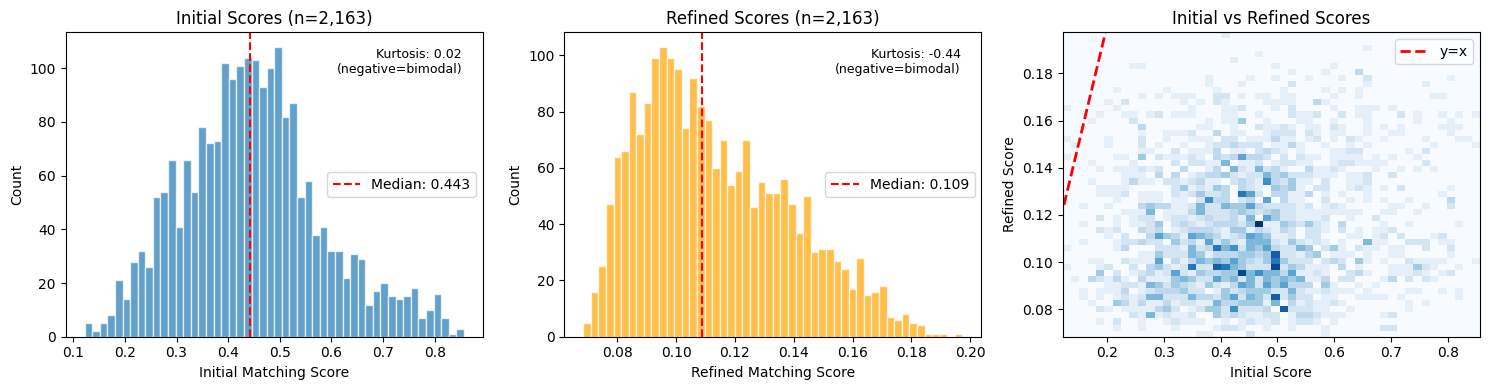


Bimodality Analysis:
Initial scores:  mean=0.449, std=0.136, kurtosis=0.02
Refined scores:  mean=0.114, std=0.025, kurtosis=-0.44

→ Similar bimodality before and after CCA
  Bimodality is inherent in the data, not created by CCA


In [50]:
# DIAGNOSTIC: Compare initial vs refined - does CCA create the bimodality?

init_match = fusor._init_matching[0]
init_rows, init_cols, init_scores_arr = init_match
init_scores_arr = np.array(init_scores_arr)

refined_match = fusor._refined_matching[0]
refined_rows, refined_cols, ref_scores_arr = refined_match
ref_scores_arr = np.array(ref_scores_arr)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Initial score distribution
ax = axes[0]
ax.hist(init_scores_arr, bins=50, edgecolor='white', alpha=0.7)
ax.set_xlabel('Initial Matching Score')
ax.set_ylabel('Count')
ax.set_title(f'Initial Scores (n={len(init_scores_arr):,})')
ax.axvline(np.median(init_scores_arr), color='red', linestyle='--', label=f'Median: {np.median(init_scores_arr):.3f}')
ax.legend()

# Check if initial is bimodal
from scipy.stats import kurtosis
init_kurtosis = kurtosis(init_scores_arr)
ax.text(0.95, 0.95, f'Kurtosis: {init_kurtosis:.2f}\n(negative=bimodal)', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9)

# 2. Refined score distribution  
ax = axes[1]
ax.hist(ref_scores_arr, bins=50, edgecolor='white', alpha=0.7, color='orange')
ax.set_xlabel('Refined Matching Score')
ax.set_ylabel('Count')
ax.set_title(f'Refined Scores (n={len(ref_scores_arr):,})')
ax.axvline(np.median(ref_scores_arr), color='red', linestyle='--', label=f'Median: {np.median(ref_scores_arr):.3f}')
ax.legend()

ref_kurtosis = kurtosis(ref_scores_arr)
ax.text(0.95, 0.95, f'Kurtosis: {ref_kurtosis:.2f}\n(negative=bimodal)', 
        transform=ax.transAxes, ha='right', va='top', fontsize=9)

# 3. Score change scatter (for matched pairs that exist in both)
ax = axes[2]
# The refined matching should have same pairs as initial (just reordered by score)
# Plot score comparison
ax.hist2d(init_scores_arr, ref_scores_arr, bins=50, cmap='Blues')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
ax.set_xlabel('Initial Score')
ax.set_ylabel('Refined Score')
ax.set_title('Initial vs Refined Scores')
ax.legend()

plt.tight_layout()
plt.show()

# Summary
print("\nBimodality Analysis:")
print("=" * 50)
print(f"Initial scores:  mean={init_scores_arr.mean():.3f}, std={init_scores_arr.std():.3f}, kurtosis={init_kurtosis:.2f}")
print(f"Refined scores:  mean={ref_scores_arr.mean():.3f}, std={ref_scores_arr.std():.3f}, kurtosis={ref_kurtosis:.2f}")
print()
if ref_kurtosis < init_kurtosis - 0.5:
    print("→ CCA refinement INCREASED bimodality (kurtosis decreased)")
    print("  This suggests CCA is separating good/bad matches more clearly")
elif ref_kurtosis > init_kurtosis + 0.5:
    print("→ CCA refinement REDUCED bimodality")
else:
    print("→ Similar bimodality before and after CCA")
    print("  Bimodality is inherent in the data, not created by CCA")

In [51]:
# Filter bad pivots using GMM-guided threshold
# The GMM analysis (previous cell) identifies the fraction of matches in the "bad mode"
# Use that fraction (with a small margin) instead of a fixed 20%

# GMM-guided filtering: use bad_mode_fraction from previous cell
# Add small margin (0.02) to be slightly conservative, cap at 0.2 max
pivot_filter_prop = min(0.2, bad_mode_fraction + 0.02)

print(f"GMM-guided pivot filter:")
print(f"  Bad mode fraction: {bad_mode_fraction:.2%}")
print(f"  Filter proportion: {pivot_filter_prop:.2%} (bad_mode + 2% margin, max 20%)")

fusor.filter_bad_matches(
    target='pivot',
    filter_prop=pivot_filter_prop,
    verbose=True
)

print(f"\nFiltered {pivot_filter_prop*100:.1f}% of lowest-scoring pivots")

GMM-guided pivot filter:
  Bad mode fraction: 39.71%
  Filter proportion: 20.00% (bad_mode + 2% margin, max 20%)
Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
Now at batch 2<->0...
Now at batch 3<->0...
Now at batch 4<->0...
8652/10817 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
8652/10817 cells in arr1 are selected as pivots.
5244/19358 cells in arr2 are selected as pivots.
Done!

Filtered 20.0% of lowest-scoring pivots


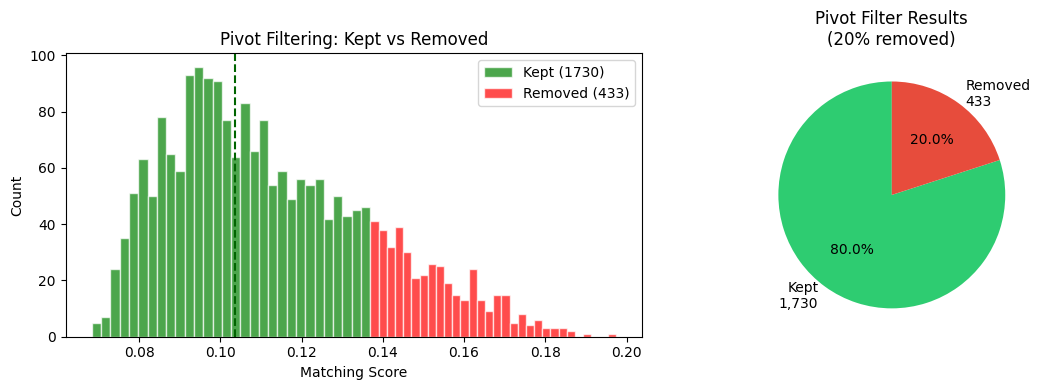

Pivot filtering: 1,730 kept, 433 removed
Mean score - Kept: 0.1037, Removed: 0.1528


In [52]:
# Visualize pivot filtering results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Get remaining indices
remaining_idx = fusor._remaining_indices_in_refined_matching[0]
kept_scores = ref_scores[remaining_idx]
removed_scores = np.delete(ref_scores, remaining_idx)

# Score distributions: kept vs removed
ax = axes[0]
ax.hist(kept_scores, bins=30, alpha=0.7, label=f'Kept ({len(kept_scores)})', color='green', edgecolor='white')
if len(removed_scores) > 0:
    ax.hist(removed_scores, bins=30, alpha=0.7, label=f'Removed ({len(removed_scores)})', color='red', edgecolor='white')
ax.axvline(np.mean(kept_scores), color='darkgreen', linestyle='--')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Pivot Filtering: Kept vs Removed')
ax.legend()

# Summary pie chart
ax = axes[1]
sizes = [len(kept_scores), len(removed_scores)]
labels = [f'Kept\n{len(kept_scores):,}', f'Removed\n{len(removed_scores):,}']
colors = ['#2ecc71', '#e74c3c']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
pct_removed = 100 * len(removed_scores) / (len(kept_scores) + len(removed_scores))
ax.set_title(f'Pivot Filter Results\n({pct_removed:.0f}% removed)')

plt.tight_layout()
plt.show()

print(f"Pivot filtering: {len(kept_scores):,} kept, {len(removed_scores):,} removed")
if len(removed_scores) > 0:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}, Removed: {np.mean(removed_scores):.4f}")
else:
    print(f"Mean score - Kept: {np.mean(kept_scores):.4f}")


In [53]:
# Propagate to all cells
# Use same SVD limits as refine_pivots for consistency
fusor.propagate(
    svd_components1=min(50, n_rna_features - 1),   # RNA: plenty of headroom
    svd_components2=min(15, n_prot_features - 1),  # Protein: cap at 15 for 19 markers
    wt1=0.7,
    wt2=0.7,
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Now at batch 2<->0...
Now at batch 3<->0...
Now at batch 4<->0...
Done!


In [54]:
# DEBUG: Trace where Pancreas RNA cells are lost in the pipeline
rna_tissue = rna_adata.obs['Tissue'].values
protein_tissue = protein_adata.obs['Tissue'].values
pancreas_rna_idx = set(np.where(rna_tissue == 'Pancreas')[0])
pln_rna_idx = set(np.where(rna_tissue == 'pLN')[0])

print(f"=== PANCREAS RNA CELL TRACING ===")
print(f"Total Pancreas RNA cells: {len(pancreas_rna_idx)}")
print(f"Total pLN RNA cells: {len(pln_rna_idx)}")

# Check batching - are Pancreas cells in the batches?
print(f"\n--- Batching ---")
for b, indices in enumerate(fusor._batch_to_indices1):
    batch_set = set(indices)
    batch_pancreas = len(batch_set & pancreas_rna_idx)
    batch_pln = len(batch_set & pln_rna_idx)
    if batch_pancreas > 0 or batch_pln > 0:
        print(f"  Batch {b}: {batch_pancreas} Pancreas, {batch_pln} pLN cells")

# Build metacell -> cell mapping if using metacells
metacell_to_cells = {}
if fusor.metacell_size > 1 and fusor._metacell_labels1 is not None:
    for b, mc_labels in enumerate(fusor._metacell_labels1):
        batch_indices = fusor._batch_to_indices1[b]
        metacell_to_cells[b] = {}
        for cell_local_idx, mc_idx in enumerate(mc_labels):
            if mc_idx not in metacell_to_cells[b]:
                metacell_to_cells[b][mc_idx] = []
            metacell_to_cells[b][mc_idx].append(batch_indices[cell_local_idx])

# Manually convert propagated matching indices to global indices
print(f"\n--- Propagated Matches (before filtering) ---")
all_rna_global = []
all_prot_global = []
all_scores = []

for batch_idx, (b1, b2) in enumerate(fusor._batch1_to_batch2):
    rows, cols, scores = fusor._propagated_matching[batch_idx]
    batch_indices1 = fusor._batch_to_indices1[b1]
    batch_indices2 = fusor._batch_to_indices2[b2]
    
    for r, c, s in zip(rows, cols, scores):
        # Protein index is straightforward
        global_prot = batch_indices2[c] if c < len(batch_indices2) else None
        if global_prot is None:
            continue
            
        # RNA index depends on whether metacells are used
        if fusor.metacell_size > 1 and b1 in metacell_to_cells:
            # r could be a metacell index - get all cells in that metacell
            if r in metacell_to_cells[b1]:
                for global_rna in metacell_to_cells[b1][r]:
                    all_rna_global.append(global_rna)
                    all_prot_global.append(global_prot)
                    all_scores.append(s)
            elif r < len(batch_indices1):
                # r is a direct cell index (non-pivot cell)
                all_rna_global.append(batch_indices1[r])
                all_prot_global.append(global_prot)
                all_scores.append(s)
        else:
            if r < len(batch_indices1):
                all_rna_global.append(batch_indices1[r])
                all_prot_global.append(global_prot)
                all_scores.append(s)

all_rna_global = np.array(all_rna_global)
all_prot_global = np.array(all_prot_global)

print(f"Total matches: {len(all_rna_global):,}")
print(f"Unique RNA cells: {len(np.unique(all_rna_global)):,}")
print(f"Unique Protein cells: {len(np.unique(all_prot_global)):,}")

# Count by tissue
pancreas_matched = sum(1 for r in all_rna_global if r in pancreas_rna_idx)
pln_matched = sum(1 for r in all_rna_global if r in pln_rna_idx)
print(f"\nRNA tissue breakdown:")
print(f"  Pancreas RNA matches: {pancreas_matched:,}")
print(f"  pLN RNA matches: {pln_matched:,}")

# Tissue pair breakdown  
tissue_pairs = {'Pancreas→Pancreas': 0, 'Pancreas→pLN': 0, 'pLN→Pancreas': 0, 'pLN→pLN': 0}
for r, c in zip(all_rna_global, all_prot_global):
    rna_t = rna_tissue[r]
    prot_t = protein_tissue[c]
    pair = f"{rna_t}→{prot_t}"
    tissue_pairs[pair] = tissue_pairs.get(pair, 0) + 1

print(f"\nTissue pair counts:")
for pair, count in sorted(tissue_pairs.items()):
    print(f"  {pair}: {count:,}")

print(f"===================================")

=== PANCREAS RNA CELL TRACING ===
Total Pancreas RNA cells: 676
Total pLN RNA cells: 10141

--- Batching ---
  Batch 0: 116 Pancreas, 2047 pLN cells
  Batch 1: 139 Pancreas, 2024 pLN cells
  Batch 2: 148 Pancreas, 2015 pLN cells
  Batch 3: 143 Pancreas, 2020 pLN cells
  Batch 4: 130 Pancreas, 2035 pLN cells

--- Propagated Matches (before filtering) ---
Total matches: 90,303
Unique RNA cells: 9,351
Unique Protein cells: 19,327

RNA tissue breakdown:
  Pancreas RNA matches: 14,894
  pLN RNA matches: 75,409

Tissue pair counts:
  Pancreas→Pancreas: 12,597
  Pancreas→pLN: 2,297
  pLN→Pancreas: 8,069
  pLN→pLN: 67,340


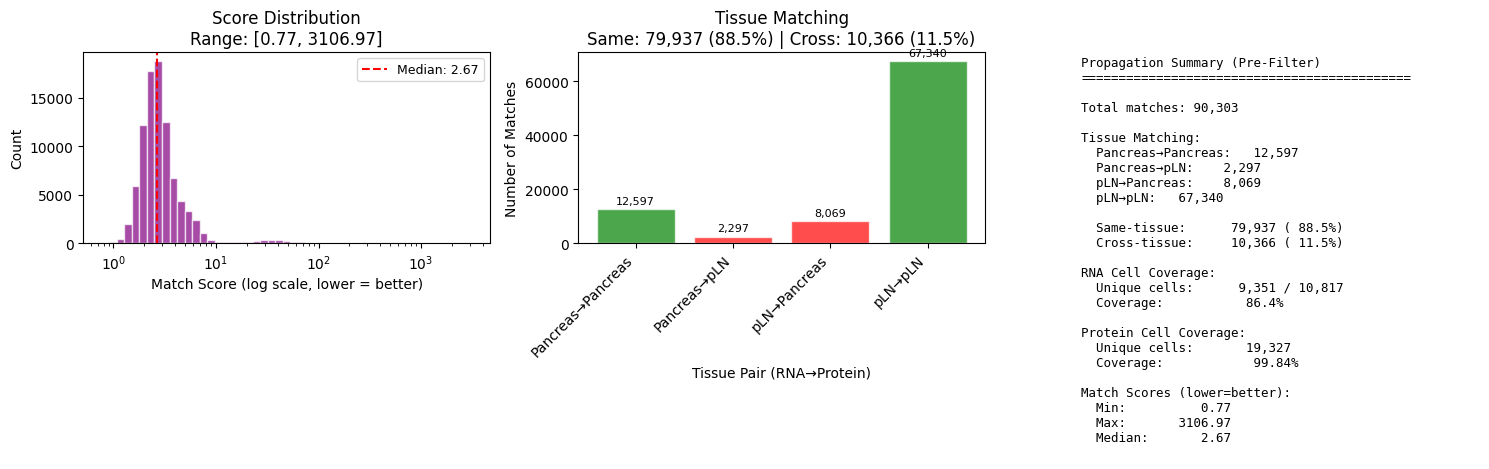

In [55]:
# Visualize propagation results (before filtering)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Build metacell -> cell mapping if using metacells
metacell_to_cells = {}
if fusor.metacell_size > 1 and fusor._metacell_labels1 is not None:
    for b, mc_labels in enumerate(fusor._metacell_labels1):
        batch_indices = fusor._batch_to_indices1[b]
        metacell_to_cells[b] = {}
        for cell_local_idx, mc_idx in enumerate(mc_labels):
            if mc_idx not in metacell_to_cells[b]:
                metacell_to_cells[b][mc_idx] = []
            metacell_to_cells[b][mc_idx].append(batch_indices[cell_local_idx])

# Convert propagated matching indices to global indices
all_rna_global = []
all_prot_global = []
all_scores = []

for batch_idx, (b1, b2) in enumerate(fusor._batch1_to_batch2):
    rows, cols, scores = fusor._propagated_matching[batch_idx]
    batch_indices1 = fusor._batch_to_indices1[b1]
    batch_indices2 = fusor._batch_to_indices2[b2]
    
    for r, c, s in zip(rows, cols, scores):
        global_prot = batch_indices2[c] if c < len(batch_indices2) else None
        if global_prot is None:
            continue
            
        if fusor.metacell_size > 1 and b1 in metacell_to_cells:
            if r in metacell_to_cells[b1]:
                for global_rna in metacell_to_cells[b1][r]:
                    all_rna_global.append(global_rna)
                    all_prot_global.append(global_prot)
                    all_scores.append(s)
            elif r < len(batch_indices1):
                all_rna_global.append(batch_indices1[r])
                all_prot_global.append(global_prot)
                all_scores.append(s)
        else:
            if r < len(batch_indices1):
                all_rna_global.append(batch_indices1[r])
                all_prot_global.append(global_prot)
                all_scores.append(s)

all_rna_global = np.array(all_rna_global)
all_prot_global = np.array(all_prot_global)
all_scores = np.array(all_scores)

# Get tissue labels
rna_tissue = rna_adata.obs['Tissue'].values
protein_tissue = protein_adata.obs['Tissue'].values

# Plot 1: Match score distribution
ax = axes[0]
score_min, score_max = all_scores.min(), all_scores.max()
if score_max / (score_min + 1e-10) > 100:
    bins = np.logspace(np.log10(max(score_min, 0.01)), np.log10(score_max), 50)
    ax.hist(all_scores, bins=bins, color='purple', alpha=0.7, edgecolor='white')
    ax.set_xscale('log')
    ax.set_xlabel('Match Score (log scale, lower = better)')
else:
    bins = np.linspace(score_min, score_max, 50)
    ax.hist(all_scores, bins=bins, color='purple', alpha=0.7, edgecolor='white')
    ax.set_xlabel('Match Score (lower = better)')
ax.axvline(np.median(all_scores), color='r', linestyle='--', 
           label=f'Median: {np.median(all_scores):.2f}')
ax.set_ylabel('Count')
ax.set_title(f'Score Distribution\nRange: [{score_min:.2f}, {score_max:.2f}]')
ax.legend(fontsize=9)

# Plot 2: Tissue matching breakdown
ax = axes[1]
tissue_pairs = {'Pancreas→Pancreas': 0, 'Pancreas→pLN': 0, 'pLN→Pancreas': 0, 'pLN→pLN': 0}
for r, c in zip(all_rna_global, all_prot_global):
    rna_t = rna_tissue[r]
    prot_t = protein_tissue[c]
    pair = f"{rna_t}→{prot_t}"
    tissue_pairs[pair] = tissue_pairs.get(pair, 0) + 1

same_tissue = tissue_pairs['Pancreas→Pancreas'] + tissue_pairs['pLN→pLN']
cross_tissue = tissue_pairs['Pancreas→pLN'] + tissue_pairs['pLN→Pancreas']

pairs = ['Pancreas→Pancreas', 'Pancreas→pLN', 'pLN→Pancreas', 'pLN→pLN']
counts = [tissue_pairs[p] for p in pairs]
colors = ['green', 'red', 'red', 'green']
bars = ax.bar(range(len(pairs)), counts, color=colors, alpha=0.7, edgecolor='white')
ax.set_xticks(range(len(pairs)))
ax.set_xticklabels(pairs, rotation=45, ha='right')
ax.set_xlabel('Tissue Pair (RNA→Protein)')
ax.set_ylabel('Number of Matches')
total_matches = len(all_rna_global)
same_pct = 100*same_tissue/total_matches if total_matches > 0 else 0
cross_pct = 100*cross_tissue/total_matches if total_matches > 0 else 0
ax.set_title(f'Tissue Matching\nSame: {same_tissue:,} ({same_pct:.1f}%) | Cross: {cross_tissue:,} ({cross_pct:.1f}%)')
max_count = max(counts) if counts and max(counts) > 0 else 1
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.02, 
            f'{count:,}', ha='center', va='bottom', fontsize=8)

# Plot 3: Summary statistics
ax = axes[2]
ax.axis('off')

total_rna = rna_active.shape[0]
total_prot = protein_active.shape[0]
rna_unique = len(np.unique(all_rna_global))
prot_unique = len(np.unique(all_prot_global))

tissue_summary = "\n".join([f"  {p}: {tissue_pairs[p]:>8,}" for p in pairs])

stats = f"""Propagation Summary (Pre-Filter)
{"="*44}

Total matches: {total_matches:,}

Tissue Matching:
{tissue_summary}
  
  Same-tissue:    {same_tissue:>8,} ({same_pct:>5.1f}%)
  Cross-tissue:   {cross_tissue:>8,} ({cross_pct:>5.1f}%)

RNA Cell Coverage:
  Unique cells:   {rna_unique:>8,} / {total_rna:,}
  Coverage:       {100*rna_unique/total_rna:>8.1f}%

Protein Cell Coverage:
  Unique cells:   {prot_unique:>10,}
  Coverage:       {100*prot_unique/total_prot:>10.2f}%

Match Scores (lower=better):
  Min:    {score_min:>10.2f}
  Max:    {score_max:>10.2f}
  Median: {np.median(all_scores):>10.2f}
"""
ax.text(0.02, 0.98, stats, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [56]:
# Filter propagated matches
# NOTE: Using more conservative filtering (5%) to maximize coverage
# The pivot filtering already removed poor matches; be gentle here
propagate_filter_prop = 0.05  # Remove bottom 5% (was 10%)

fusor.filter_bad_matches(
    target='propagated',
    filter_prop=propagate_filter_prop,
    verbose=True
)

print(f"\nFiltered {propagate_filter_prop*100:.0f}% of lowest-scoring propagated matches")

Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
Now at batch 2<->0...
Now at batch 3<->0...
Now at batch 4<->0...
85788/90303 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!

Filtered 5% of lowest-scoring propagated matches


In [57]:
# Get full matching - RNA-CENTRIC
# order=(1,2) ensures each RNA cell gets at least one protein match
# This gives ~1,284 matches (one per RNA) instead of ~1.7M (one per protein)
full_matching = fusor.get_matching(order=(1, 2), target='full_data')

print(f"\nMaxFuse Full matching results (RNA-centric):")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")


MaxFuse Full matching results (RNA-centric):
  Total matches: 8661
  Unique RNA cells: 8661
  Unique Protein cells: 5244
  Score range: [-0.519, 0.991]


Score threshold selection:
  Threshold: 0.118
  Reason: GMM-guided (bad mode = 39.7%)

Score threshold filtering (min score >= 0.118):
  Original matches: 8,661
  Removed (score < 0.118): 430 (5.0%)
  Remaining matches: 8,231

Score statistics after filtering:
  Min:    0.1182
  Max:    0.9915
  Mean:   0.5999
  Median: 0.6198


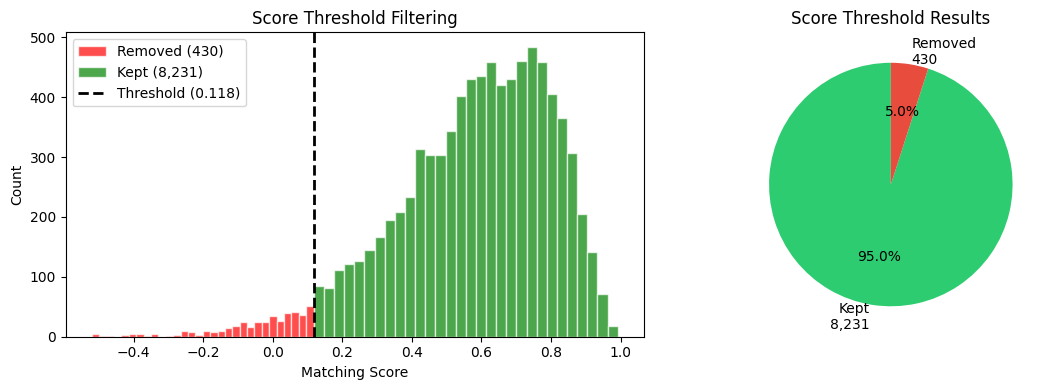

In [58]:
# Apply score threshold to remove low-quality matches
# Use GMM-guided threshold if bimodal distribution detected, otherwise keep all positive

# Check if GMM analysis detected significant bad mode
if 'gmm_threshold' in dir() and 'bad_mode_fraction' in dir():
    # Use GMM threshold if bad mode is substantial (>10% of matches)
    if bad_mode_fraction > 0.10:
        MIN_SCORE_THRESHOLD = gmm_threshold
        threshold_reason = f"GMM-guided (bad mode = {bad_mode_fraction:.1%})"
    else:
        MIN_SCORE_THRESHOLD = 0.0
        threshold_reason = f"Default (bad mode only {bad_mode_fraction:.1%}, not significant)"
else:
    MIN_SCORE_THRESHOLD = 0.0
    threshold_reason = "Default (GMM analysis not run)"

print(f"Score threshold selection:")
print(f"  Threshold: {MIN_SCORE_THRESHOLD:.3f}")
print(f"  Reason: {threshold_reason}")

# Get original stats
n_original = len(full_matching[0])
scores = np.array(full_matching[2])

# Filter by threshold
mask = scores >= MIN_SCORE_THRESHOLD
full_matching_filtered = (
    np.array(full_matching[0])[mask],
    np.array(full_matching[1])[mask],
    scores[mask]
)

n_filtered = len(full_matching_filtered[0])
n_removed = n_original - n_filtered

print(f"\nScore threshold filtering (min score >= {MIN_SCORE_THRESHOLD:.3f}):")
print(f"  Original matches: {n_original:,}")
print(f"  Removed (score < {MIN_SCORE_THRESHOLD:.3f}): {n_removed:,} ({100*n_removed/n_original:.1f}%)")
print(f"  Remaining matches: {n_filtered:,}")
print(f"")
print(f"Score statistics after filtering:")
print(f"  Min:    {np.min(full_matching_filtered[2]):.4f}")
print(f"  Max:    {np.max(full_matching_filtered[2]):.4f}")
print(f"  Mean:   {np.mean(full_matching_filtered[2]):.4f}")
print(f"  Median: {np.median(full_matching_filtered[2]):.4f}")

# Update full_matching to use filtered version
full_matching = full_matching_filtered

# Visualize what was removed
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
if n_removed > 0:
    ax.hist(scores[~mask], bins=30, alpha=0.7, color='red', label=f'Removed ({n_removed:,})', edgecolor='white')
ax.hist(scores[mask], bins=30, alpha=0.7, color='green', label=f'Kept ({n_filtered:,})', edgecolor='white')
ax.axvline(MIN_SCORE_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({MIN_SCORE_THRESHOLD:.3f})')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Score Threshold Filtering')
ax.legend()

ax = axes[1]
if n_removed > 0:
    sizes = [n_filtered, n_removed]
    colors = ['#2ecc71', '#e74c3c']
    labels = [f'Kept\n{n_filtered:,}', f'Removed\n{n_removed:,}']
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Score Threshold Results')
else:
    ax.text(0.5, 0.5, f'All {n_filtered:,} matches\nkept (score >= {MIN_SCORE_THRESHOLD:.3f})', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))
    ax.set_title('Score Threshold Results')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [59]:
# Verify matching cardinality (RNA-centric approach)
print("=" * 60)
print("MATCHING CARDINALITY VERIFICATION (RNA-CENTRIC)")
print("=" * 60)

n_total_matches = len(full_matching[0])
n_unique_rna = len(np.unique(full_matching[0]))
n_unique_protein = len(np.unique(full_matching[1]))

print(f"Total matches: {n_total_matches:,}")
print(f"Unique RNA matched: {n_unique_rna:,} / {rna_active.shape[0]} ({100*n_unique_rna/rna_active.shape[0]:.1f}%)")
print(f"Unique protein matched: {n_unique_protein:,} / {protein_active.shape[0]} ({100*n_unique_protein/protein_active.shape[0]:.1f}%)")
print(f"")
print(f"Score range: [{full_matching[2].min():.3f}, {full_matching[2].max():.3f}]")
print(f"Mean score: {full_matching[2].mean():.3f}")
print(f"")

# With RNA-centric matching, we expect ~1 match per RNA cell
avg_matches_per_rna = n_total_matches / n_unique_rna if n_unique_rna > 0 else 0
print(f"Avg matches per RNA: {avg_matches_per_rna:.1f}")

# Check RNA coverage
rna_coverage = n_unique_rna / rna_active.shape[0] * 100
if rna_coverage >= 90:
    print(f"\n✓ Good RNA coverage ({rna_coverage:.1f}%)")
else:
    print(f"\n⚠️  Low RNA coverage ({rna_coverage:.1f}%) - some RNA cells unmatched")

MATCHING CARDINALITY VERIFICATION (RNA-CENTRIC)
Total matches: 8,231
Unique RNA matched: 8,231 / 10817 (76.1%)
Unique protein matched: 5,081 / 19358 (26.2%)

Score range: [0.118, 0.991]
Mean score: 0.600

Avg matches per RNA: 1.0

⚠️  Low RNA coverage (76.1%) - some RNA cells unmatched


UNMATCHED RNA CELL ANALYSIS

RNA Cell Coverage:
  Matched:   8,231 (76.1%)
  Unmatched: 2,586 (23.9%)
  Total:     10,817


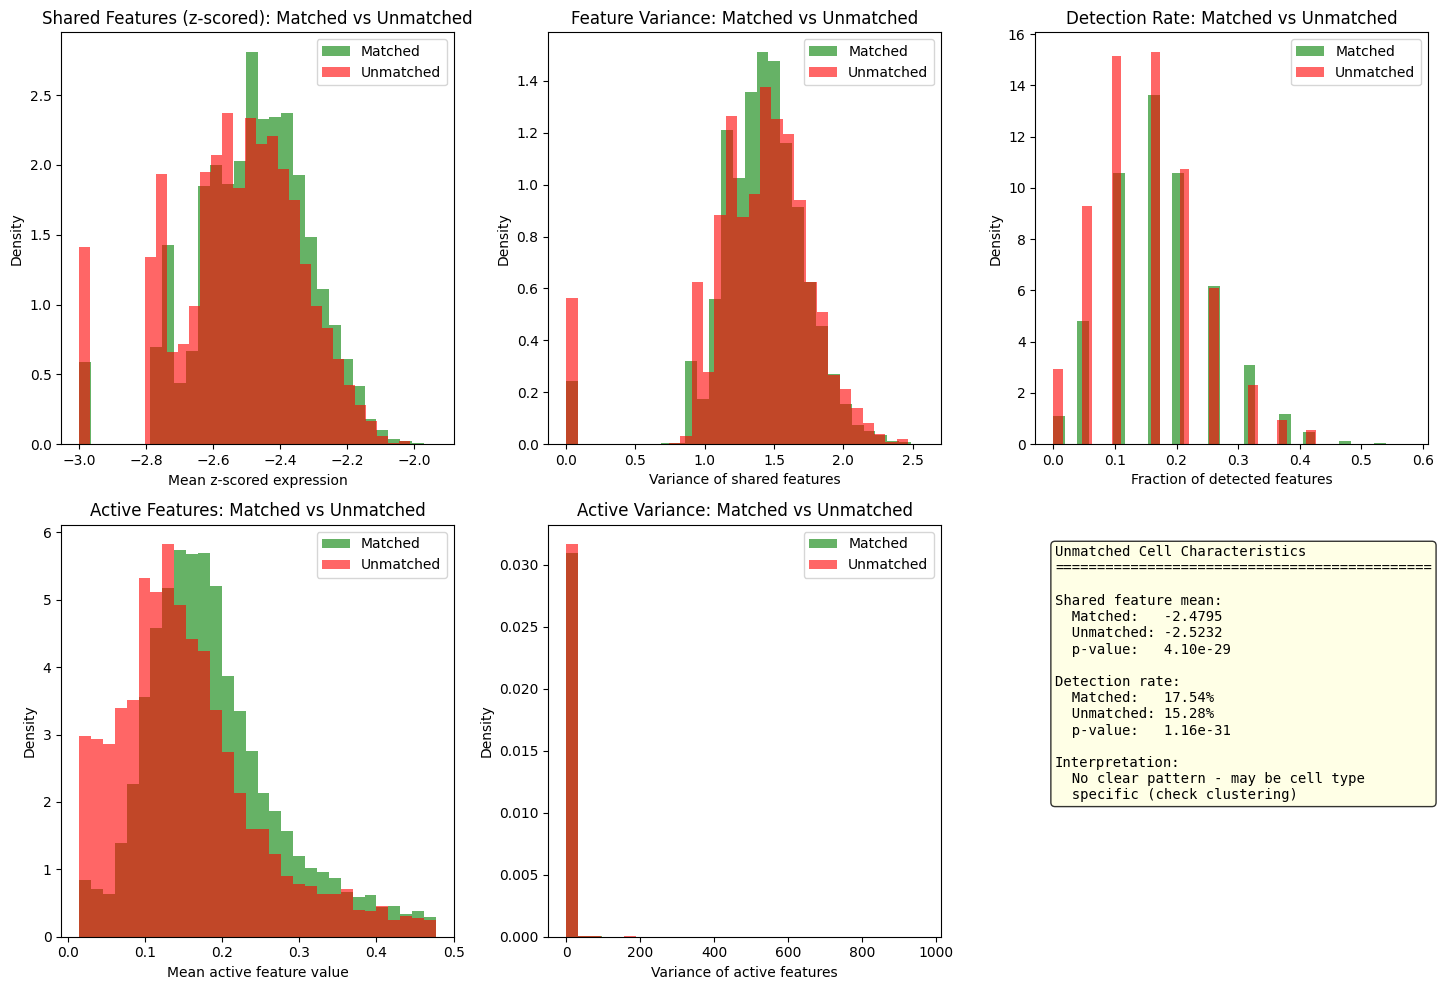


Unmatched RNA cell indices saved to 'unmatched_rna_indices'
Use these indices to investigate in notebook 3 (visualization)


In [60]:
# Investigate unmatched RNA cells
# Validate that score filtering was applied (cell 57 must run first)
assert np.min(full_matching[2]) >= MIN_SCORE_THRESHOLD, \
    f"Run the score filtering cell first! Found scores below {MIN_SCORE_THRESHOLD} in full_matching."

print("=" * 60)
print("UNMATCHED RNA CELL ANALYSIS")
print("=" * 60)

# Find matched and unmatched RNA cells
matched_rna_idx = np.unique(full_matching[0])
all_rna_idx = np.arange(rna_active.shape[0])
unmatched_rna_idx = np.setdiff1d(all_rna_idx, matched_rna_idx)

n_matched = len(matched_rna_idx)
n_unmatched = len(unmatched_rna_idx)
n_total = rna_active.shape[0]

print(f"\nRNA Cell Coverage:")
print(f"  Matched:   {n_matched:,} ({100*n_matched/n_total:.1f}%)")
print(f"  Unmatched: {n_unmatched:,} ({100*n_unmatched/n_total:.1f}%)")
print(f"  Total:     {n_total:,}")

# Save unmatched indices for further analysis
unmatched_rna_indices = unmatched_rna_idx

if n_unmatched == 0:
    print("\n*** All RNA cells matched! ***")
    print("No unmatched analysis needed.")
else:
    # Compare feature distributions: matched vs unmatched
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Shared feature means
    ax = axes[0, 0]
    matched_shared_mean = rna_shared[matched_rna_idx].mean(axis=1)
    unmatched_shared_mean = rna_shared[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_shared_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean z-scored expression')
    ax.set_ylabel('Density')
    ax.set_title('Shared Features (z-scored): Matched vs Unmatched')
    ax.legend()

    # Shared feature variance
    ax = axes[0, 1]
    matched_shared_var = rna_shared[matched_rna_idx].var(axis=1)
    unmatched_shared_var = rna_shared[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_shared_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_shared_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of shared features')
    ax.set_ylabel('Density')
    ax.set_title('Feature Variance: Matched vs Unmatched')
    ax.legend()

    # Detection rate (non-zero features)
    ax = axes[0, 2]
    # Use detection mask from normalization (non-zero after log1p)
    matched_detection = rna_detection_mask[matched_rna_idx].mean(axis=1)
    unmatched_detection = rna_detection_mask[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_detection, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_detection, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Fraction of detected features')
    ax.set_ylabel('Density')
    ax.set_title('Detection Rate: Matched vs Unmatched')
    ax.legend()

    # Active feature mean
    ax = axes[1, 0]
    matched_active_mean = rna_active[matched_rna_idx].mean(axis=1)
    unmatched_active_mean = rna_active[unmatched_rna_idx].mean(axis=1)
    ax.hist(matched_active_mean, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_mean, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Mean active feature value')
    ax.set_ylabel('Density')
    ax.set_title('Active Features: Matched vs Unmatched')
    ax.legend()

    # Active feature variance  
    ax = axes[1, 1]
    matched_active_var = rna_active[matched_rna_idx].var(axis=1)
    unmatched_active_var = rna_active[unmatched_rna_idx].var(axis=1)
    ax.hist(matched_active_var, bins=30, alpha=0.6, label='Matched', color='green', density=True)
    ax.hist(unmatched_active_var, bins=30, alpha=0.6, label='Unmatched', color='red', density=True)
    ax.set_xlabel('Variance of active features')
    ax.set_ylabel('Density')
    ax.set_title('Active Variance: Matched vs Unmatched')
    ax.legend()

    # Summary statistics
    ax = axes[1, 2]
    ax.axis('off')

    # Statistical comparison
    from scipy import stats
    t_stat_shared, p_shared = stats.ttest_ind(matched_shared_mean, unmatched_shared_mean)
    t_stat_detect, p_detect = stats.ttest_ind(matched_detection, unmatched_detection)

    summary = f"""Unmatched Cell Characteristics
{"="*45}

Shared feature mean:
  Matched:   {np.mean(matched_shared_mean):.4f}
  Unmatched: {np.mean(unmatched_shared_mean):.4f}
  p-value:   {p_shared:.2e}

Detection rate:
  Matched:   {np.mean(matched_detection):.2%}
  Unmatched: {np.mean(unmatched_detection):.2%}
  p-value:   {p_detect:.2e}

Interpretation:
"""

    if np.mean(unmatched_detection) < np.mean(matched_detection) - 0.05:
        summary += "  Unmatched cells have LOWER detection\n"
        summary += "  (sparse profiles harder to match)"
    elif np.mean(unmatched_shared_mean) < np.mean(matched_shared_mean) - 0.1:
        summary += "  Unmatched cells have LOWER expression\n"
        summary += "  (low signal harder to match)"
    else:
        summary += "  No clear pattern - may be cell type\n"
        summary += "  specific (check clustering)"

    ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

print(f"\nUnmatched RNA cell indices saved to 'unmatched_rna_indices'")
print(f"Use these indices to investigate in notebook 3 (visualization)")


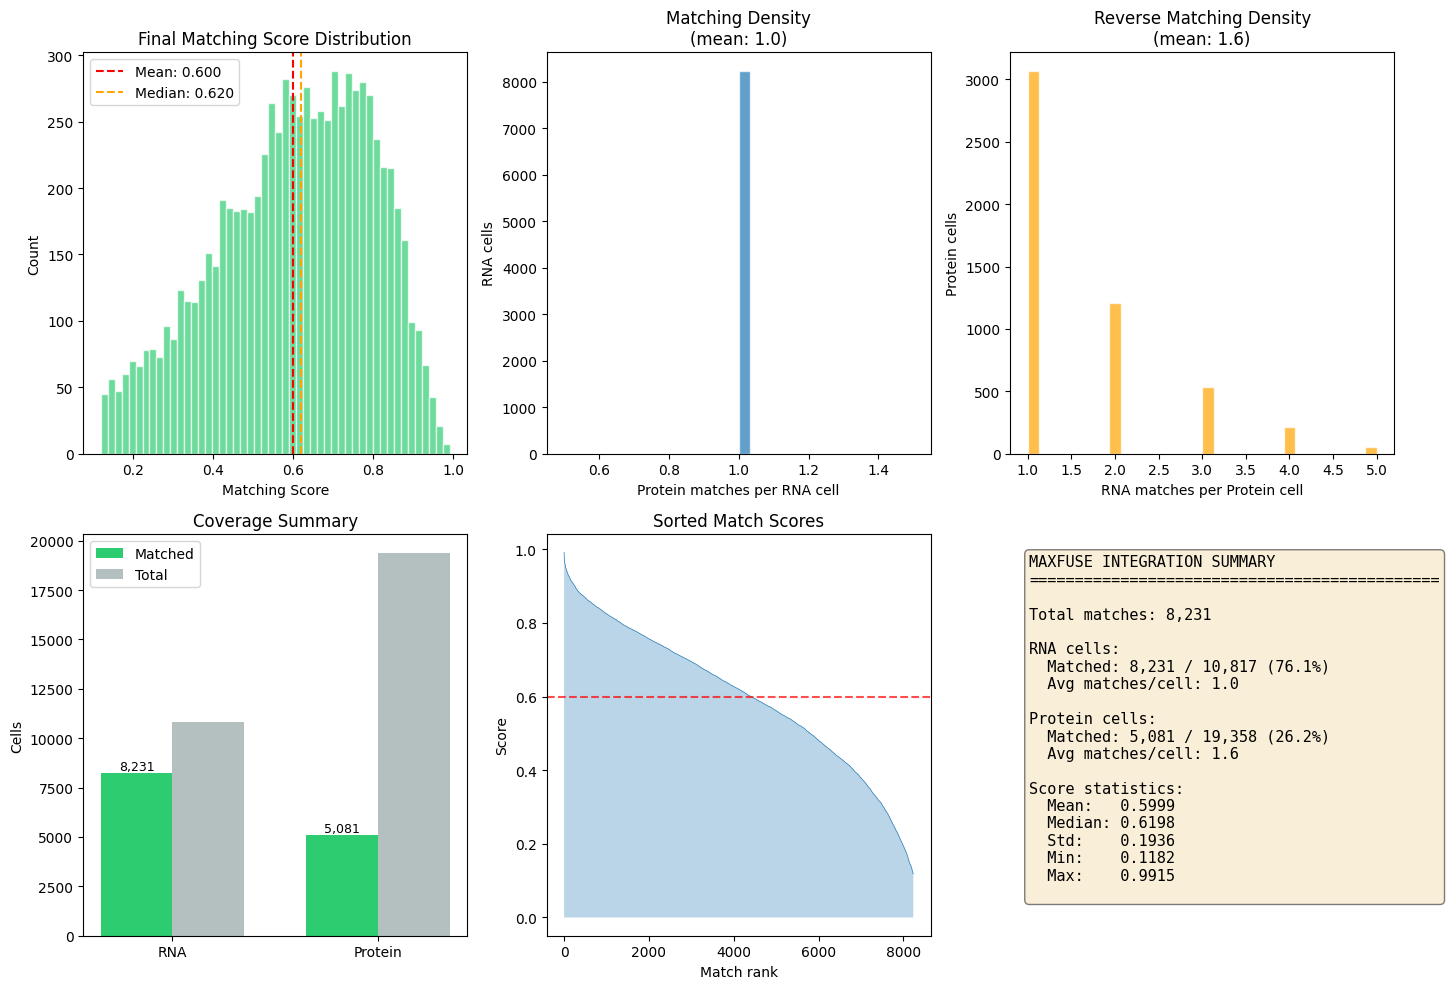

In [61]:
# Comprehensive final matching visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Score distribution
ax = axes[0, 0]
ax.hist(full_matching[2], bins=50, edgecolor='white', alpha=0.7, color='#2ecc71')
ax.axvline(np.mean(full_matching[2]), color='r', linestyle='--',
           label=f'Mean: {np.mean(full_matching[2]):.3f}')
ax.axvline(np.median(full_matching[2]), color='orange', linestyle='--',
           label=f'Median: {np.median(full_matching[2]):.3f}')
ax.set_xlabel('Matching Score')
ax.set_ylabel('Count')
ax.set_title('Final Matching Score Distribution')
ax.legend()

# Matches per RNA cell
ax = axes[0, 1]
rna_match_counts = np.bincount(full_matching[0], minlength=rna_active.shape[0])
ax.hist(rna_match_counts[rna_match_counts > 0], bins=30, edgecolor='white', alpha=0.7)
ax.set_xlabel('Protein matches per RNA cell')
ax.set_ylabel('RNA cells')
ax.set_title(f'Matching Density\n(mean: {np.mean(rna_match_counts[rna_match_counts > 0]):.1f})')

# Matches per Protein cell
ax = axes[0, 2]
prot_match_counts = np.bincount(full_matching[1], minlength=protein_active.shape[0])
ax.hist(prot_match_counts[prot_match_counts > 0], bins=30, edgecolor='white', alpha=0.7, color='orange')
ax.set_xlabel('RNA matches per Protein cell')
ax.set_ylabel('Protein cells')
ax.set_title(f'Reverse Matching Density\n(mean: {np.mean(prot_match_counts[prot_match_counts > 0]):.1f})')

# Coverage summary
ax = axes[1, 0]
n_rna_matched = len(np.unique(full_matching[0]))
n_prot_matched = len(np.unique(full_matching[1]))
categories = ['RNA', 'Protein']
matched = [n_rna_matched, n_prot_matched]
total = [rna_active.shape[0], protein_active.shape[0]]
x = np.arange(len(categories))
width = 0.35
bars1 = ax.bar(x - width/2, matched, width, label='Matched', color='#2ecc71')
bars2 = ax.bar(x + width/2, total, width, label='Total', color='#95a5a6', alpha=0.7)
ax.set_ylabel('Cells')
ax.set_title('Coverage Summary')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
for bar, val in zip(bars1, matched):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{val:,}', ha='center', va='bottom', fontsize=9)

# Score vs index (quality across matches)
ax = axes[1, 1]
sorted_scores = np.sort(full_matching[2])[::-1]
ax.plot(sorted_scores, linewidth=0.5)
ax.axhline(np.mean(full_matching[2]), color='r', linestyle='--', alpha=0.7)
ax.set_xlabel('Match rank')
ax.set_ylabel('Score')
ax.set_title('Sorted Match Scores')
ax.fill_between(range(len(sorted_scores)), sorted_scores, alpha=0.3)

# Final summary text
ax = axes[1, 2]
ax.axis('off')
coverage_rna = 100 * n_rna_matched / rna_active.shape[0]
coverage_prot = 100 * n_prot_matched / protein_active.shape[0]
summary = f'''MAXFUSE INTEGRATION SUMMARY
{"="*45}

Total matches: {len(full_matching[0]):,}

RNA cells:
  Matched: {n_rna_matched:,} / {rna_active.shape[0]:,} ({coverage_rna:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_rna_matched:.1f}

Protein cells:
  Matched: {n_prot_matched:,} / {protein_active.shape[0]:,} ({coverage_prot:.1f}%)
  Avg matches/cell: {len(full_matching[0])/n_prot_matched:.1f}

Score statistics:
  Mean:   {np.mean(full_matching[2]):.4f}
  Median: {np.median(full_matching[2]):.4f}
  Std:    {np.std(full_matching[2]):.4f}
  Min:    {np.min(full_matching[2]):.4f}
  Max:    {np.max(full_matching[2]):.4f}
'''
ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Save Integration Results

Save integration outputs for use in subsequent visualization notebooks.

CREATING ALIGNED ARRAYS AND CCA EMBEDDING

Aligned arrays created (best match per RNA cell):
  Matched pairs: 8,231
  Shared features: RNA (8231, 19), Protein (8231, 19)
  Active features: RNA (8231, 20937), Protein (8231, 19)
  Mean match score: 0.600
  Score range: [0.118, 0.991]

Variance check (should be similar):
  RNA mean variance:     1.1632
  Protein mean variance: 1.7394
  Ratio: 0.67

FITTING CCA ON SHARED FEATURES
Fitting CCA with 15 components...

Canonical correlations: [0.839 0.562 0.369 0.252 0.172 0.137 0.108 0.088 0.082 0.074 0.054 0.047
 0.043 0.039 0.034]
  Mean: 0.193
  Components > 0.5: 2/15
  Components > 0.3: 3/15

Matched pair distances in standardized CCA space:
  Mean: 4.625
  Median: 4.409
  (Lower = better alignment)


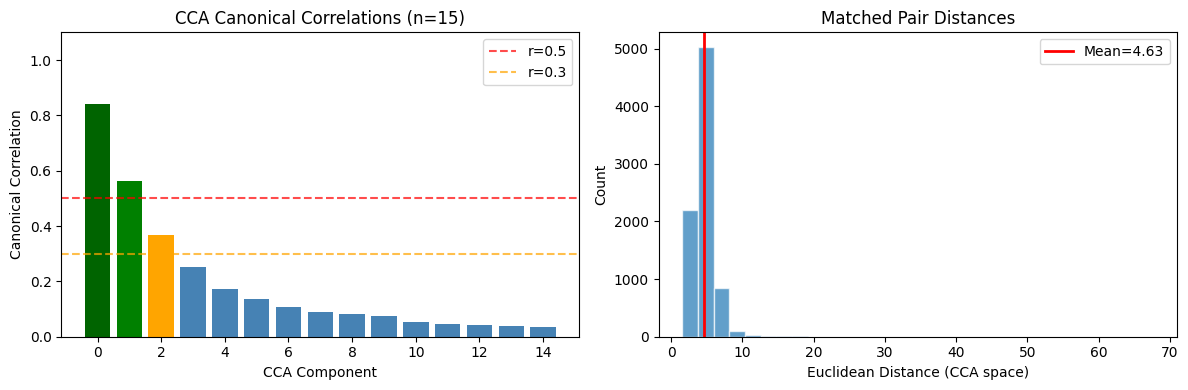


READY TO SAVE


In [62]:
# Create aligned arrays and CCA embedding for visualization
# This prepares data for notebook 3 without recomputing

from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("CREATING ALIGNED ARRAYS AND CCA EMBEDDING")
print("=" * 60)

# Build aligned arrays from the filtered matching
# Group matches by RNA cell (one RNA can match multiple protein cells)
rna_to_prot_matches = {}
for rna_idx, prot_idx, score in zip(full_matching[0], full_matching[1], full_matching[2]):
    if rna_idx not in rna_to_prot_matches:
        rna_to_prot_matches[rna_idx] = []
    rna_to_prot_matches[rna_idx].append((prot_idx, score))

# Create aligned arrays using BEST MATCH only (not averaged)
# IMPORTANT: Averaging protein cells creates variance asymmetry with single RNA cells
# Using best match preserves comparable variance in both modalities
aligned_rna_shared = []
aligned_prot_shared = []
aligned_rna_active = []
aligned_prot_active = []
aligned_rna_indices = []
aligned_prot_indices = []  # Track which protein cell was used
aligned_match_scores = []

for rna_idx, matches in rna_to_prot_matches.items():
    # Use BEST match (highest score) instead of averaging all
    best_match = max(matches, key=lambda x: x[1])
    best_prot_idx, best_score = best_match
    
    # Shared features (for CCA) - both are single cells now
    aligned_rna_shared.append(rna_shared[rna_idx])
    aligned_prot_shared.append(protein_shared[best_prot_idx])
    
    # Active features (for downstream visualization)
    aligned_rna_active.append(rna_active[rna_idx])
    aligned_prot_active.append(protein_active[best_prot_idx])
    
    aligned_rna_indices.append(rna_idx)
    aligned_prot_indices.append(best_prot_idx)
    aligned_match_scores.append(best_score)

aligned_rna_shared = np.array(aligned_rna_shared)
aligned_prot_shared = np.array(aligned_prot_shared)
aligned_rna_active = np.array(aligned_rna_active)
aligned_prot_active = np.array(aligned_prot_active)
aligned_rna_indices = np.array(aligned_rna_indices)
aligned_prot_indices = np.array(aligned_prot_indices)
aligned_match_scores = np.array(aligned_match_scores)

print(f"\nAligned arrays created (best match per RNA cell):")
print(f"  Matched pairs: {len(aligned_rna_indices):,}")
print(f"  Shared features: RNA {aligned_rna_shared.shape}, Protein {aligned_prot_shared.shape}")
print(f"  Active features: RNA {aligned_rna_active.shape}, Protein {aligned_prot_active.shape}")
print(f"  Mean match score: {aligned_match_scores.mean():.3f}")
print(f"  Score range: [{aligned_match_scores.min():.3f}, {aligned_match_scores.max():.3f}]")

# Verify variance is comparable between modalities
rna_var = aligned_rna_shared.var(axis=0).mean()
prot_var = aligned_prot_shared.var(axis=0).mean()
print(f"\nVariance check (should be similar):")
print(f"  RNA mean variance:     {rna_var:.4f}")
print(f"  Protein mean variance: {prot_var:.4f}")
print(f"  Ratio: {rna_var/prot_var:.2f}")

# Fit CCA on shared features
print(f"\n" + "=" * 60)
print("FITTING CCA ON SHARED FEATURES")
print("=" * 60)

# Standardize INPUT features before CCA
scaler_rna = StandardScaler()
scaler_prot = StandardScaler()
rna_scaled = scaler_rna.fit_transform(aligned_rna_shared)
prot_scaled = scaler_prot.fit_transform(aligned_prot_shared)

# CCA components - use as many as possible for better UMAP structure
n_cca_vis = min(15, aligned_rna_shared.shape[1] - 1, aligned_prot_shared.shape[1] - 1)
print(f"Fitting CCA with {n_cca_vis} components...")

cca_vis = CCA(n_components=n_cca_vis, max_iter=1000)
cca_vis.fit(rna_scaled, prot_scaled)

# Get CCA scores - these are the canonical variates
cca_rna_scores, cca_prot_scores = cca_vis.transform(rna_scaled, prot_scaled)

# Compute canonical correlations
canonical_correlations = np.array([
    np.corrcoef(cca_rna_scores[:, i], cca_prot_scores[:, i])[0, 1]
    for i in range(n_cca_vis)
])

print(f"\nCanonical correlations: {canonical_correlations.round(3)}")
print(f"  Mean: {canonical_correlations.mean():.3f}")
print(f"  Components > 0.5: {(canonical_correlations > 0.5).sum()}/{len(canonical_correlations)}")
print(f"  Components > 0.3: {(canonical_correlations > 0.3).sum()}/{len(canonical_correlations)}")

# Standardize CCA scores SEPARATELY per modality
# This ensures both modalities have mean=0, std=1, making matched pairs close
scaler_cca_rna = StandardScaler()
scaler_cca_prot = StandardScaler()
cca_rna_for_vis = scaler_cca_rna.fit_transform(cca_rna_scores)
cca_prot_for_vis = scaler_cca_prot.fit_transform(cca_prot_scores)

# Verify alignment is preserved after separate standardization
pair_distances = np.linalg.norm(cca_rna_for_vis - cca_prot_for_vis, axis=1)
print(f"\nMatched pair distances in standardized CCA space:")
print(f"  Mean: {pair_distances.mean():.3f}")
print(f"  Median: {np.median(pair_distances):.3f}")
print(f"  (Lower = better alignment)")

# Plot canonical correlations and pair distances
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
colors = ['darkgreen' if c > 0.7 else 'green' if c > 0.5 else 'orange' if c > 0.3 else 'steelblue' 
          for c in canonical_correlations]
ax.bar(range(len(canonical_correlations)), canonical_correlations, color=colors)
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='r=0.5')
ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='r=0.3')
ax.set_xlabel('CCA Component')
ax.set_ylabel('Canonical Correlation')
ax.set_ylim(0, 1.1)
ax.set_title(f'CCA Canonical Correlations (n={n_cca_vis})')
ax.legend()

ax = axes[1]
ax.hist(pair_distances, bins=30, edgecolor='white', alpha=0.7)
ax.axvline(pair_distances.mean(), color='red', linestyle='-', linewidth=2, label=f'Mean={pair_distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance (CCA space)')
ax.set_ylabel('Count')
ax.set_title('Matched Pair Distances')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\n" + "=" * 60)
print("READY TO SAVE")
print("=" * 60)

In [63]:
# Save integration results to results directory
import os
import pickle
from datetime import datetime
import json as json_module

# Create results directory
results_dir = '../results/2_integration'
os.makedirs(results_dir, exist_ok=True)

# Save matching results (filtered by score threshold)
matching_data = {
    'rna_indices': full_matching[0],
    'protein_indices': full_matching[1],
    'scores': full_matching[2]
}
with open(f'{results_dir}/maxfuse_matching.pkl', 'wb') as f:
    pickle.dump(matching_data, f)
print(f'Saved MaxFuse matching: {len(full_matching[0]):,} matches')

# Save as CSV for easy inspection
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.to_csv(f'{results_dir}/maxfuse_matching.csv', index=False)

# Save unmatched RNA indices for further analysis
np.save(f'{results_dir}/unmatched_rna_indices.npy', unmatched_rna_indices)
print(f'Saved unmatched RNA indices: {len(unmatched_rna_indices):,} cells')

# Save normalized arrays used for integration
np.save(f'{results_dir}/rna_shared.npy', rna_shared)
np.save(f'{results_dir}/rna_active.npy', rna_active)
np.save(f'{results_dir}/protein_shared.npy', protein_shared)
np.save(f'{results_dir}/protein_active.npy', protein_active)
print(f'Saved normalized arrays')

# Save aligned arrays for visualization (best match per RNA cell)
np.save(f'{results_dir}/aligned_rna_shared.npy', aligned_rna_shared)
np.save(f'{results_dir}/aligned_prot_shared.npy', aligned_prot_shared)
np.save(f'{results_dir}/aligned_rna_active.npy', aligned_rna_active)
np.save(f'{results_dir}/aligned_prot_active.npy', aligned_prot_active)
np.save(f'{results_dir}/aligned_rna_indices.npy', aligned_rna_indices)
np.save(f'{results_dir}/aligned_prot_indices.npy', aligned_prot_indices)
np.save(f'{results_dir}/aligned_match_scores.npy', aligned_match_scores)
print(f'Saved aligned arrays: {len(aligned_rna_indices):,} matched pairs (best match per RNA)')

# Save CCA embedding for visualization
np.save(f'{results_dir}/cca_rna_scores.npy', cca_rna_for_vis)
np.save(f'{results_dir}/cca_prot_scores.npy', cca_prot_for_vis)
np.save(f'{results_dir}/canonical_correlations.npy', canonical_correlations)
print(f'Saved CCA embedding: {cca_rna_for_vis.shape[1]} components')

# Save filtered AnnData objects (after pre-filtering in integration)
# These have fewer cells than preprocessing outputs due to non-immune cell removal
protein_adata.write(f'{results_dir}/protein_adata_filtered.h5ad')
rna_adata.write(f'{results_dir}/rna_adata_filtered.h5ad')
print(f'Saved filtered AnnData: protein {protein_adata.shape}, rna {rna_adata.shape}')

# Save correspondence table
correspondence_df = pd.DataFrame(
    rna_protein_correspondence, 
    columns=['rna_gene', 'protein_marker']
)
correspondence_df.to_csv(f'{results_dir}/correspondence.csv', index=False)

# Save integration parameters
n_matched_rna = len(np.unique(full_matching[0]))
n_matched_prot = len(np.unique(full_matching[1]))
integration_params = {
    'timestamp': datetime.now().isoformat(),
    'method': 'maxfuse',
    'score_threshold': float(MIN_SCORE_THRESHOLD),
    'score_threshold_reason': threshold_reason if 'threshold_reason' in dir() else 'unknown',
    'fusor_params': {
        'max_outward_size': max_outward,
        'matching_ratio': matching_ratio,
        'smoothing_method': fusor.method,
        'n_shared_features': rna_shared.shape[1],
        'cca_components': cca_components,
        'pivot_filter_prop': pivot_filter_prop,
        'propagate_filter_prop': propagate_filter_prop
    },
    'data_shapes': {
        'rna_cells': rna_active.shape[0],
        'protein_cells': protein_active.shape[0],
        'rna_active_features': rna_active.shape[1],
        'protein_active_features': protein_active.shape[1],
        'shared_features': rna_shared.shape[1]
    },
    'matching_stats': {
        'total_matches': len(full_matching[0]),
        'unique_rna_matched': n_matched_rna,
        'unique_protein_matched': n_matched_prot,
        'rna_coverage_pct': 100 * n_matched_rna / rna_active.shape[0],
        'protein_coverage_pct': 100 * n_matched_prot / protein_active.shape[0],
        'unmatched_rna_cells': len(unmatched_rna_indices),
        'mean_score': float(np.mean(full_matching[2])),
        'min_score': float(np.min(full_matching[2])),
        'max_score': float(np.max(full_matching[2]))
    },
    'visualization_embedding': {
        'n_cca_components': int(cca_rna_for_vis.shape[1]),
        'n_aligned_pairs': len(aligned_rna_indices),
        'alignment_method': 'best_match',  # Changed from 'averaged'
        'canonical_correlations': canonical_correlations.tolist()
    }
}
with open(f'{results_dir}/integration_params.json', 'w') as f:
    json_module.dump(integration_params, f, indent=2)

print(f'\nAll outputs saved to {results_dir}/')
print(f'  - maxfuse_matching.pkl, maxfuse_matching.csv')
print(f'  - unmatched_rna_indices.npy')
print(f'  - rna_shared.npy, rna_active.npy, protein_shared.npy, protein_active.npy')
print(f'  - aligned_*.npy (7 files for visualization, best match per RNA)')
print(f'  - cca_rna_scores.npy, cca_prot_scores.npy, canonical_correlations.npy')
print(f'  - protein_adata_filtered.h5ad, rna_adata_filtered.h5ad')
print(f'  - correspondence.csv, integration_params.json')
print(f'\nRun 3_visualization.ipynb next.')

Saved MaxFuse matching: 8,231 matches
Saved unmatched RNA indices: 2,586 cells
Saved normalized arrays
Saved aligned arrays: 8,231 matched pairs (best match per RNA)
Saved CCA embedding: 15 components
Saved filtered AnnData: protein (19358, 19), rna (10817, 20951)

All outputs saved to ../results/2_integration/
  - maxfuse_matching.pkl, maxfuse_matching.csv
  - unmatched_rna_indices.npy
  - rna_shared.npy, rna_active.npy, protein_shared.npy, protein_active.npy
  - aligned_*.npy (7 files for visualization, best match per RNA)
  - cca_rna_scores.npy, cca_prot_scores.npy, canonical_correlations.npy
  - protein_adata_filtered.h5ad, rna_adata_filtered.h5ad
  - correspondence.csv, integration_params.json

Run 3_visualization.ipynb next.
